In [1]:
import pandas as pd
import numpy as np
import os
from pybedtools import BedTool
from pybedtools import BedTool
import pybedtools
import csv


import pickle
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True) # Seaborn desaturates matplotlib colors (this is useful if you use both seaborn and basic matplot lib and want colors to be consistent)
import scipy.stats as stats
sns.set(palette='husl', context = 'talk', style='white', font_scale=1)

In [2]:
BASE_PATH = "/".join(os.getcwd().split("/")) # base directory level


#Wynton
BIN_PATH = os.path.join(BASE_PATH, "bin")  # where my scripts live
DATA_PATH = os.path.join(BASE_PATH, "data")  # where I dump new data 
RESULTS_PATH = os.path.join(BASE_PATH, "results")  # where I analyze results


# More divergent than expected

## Set up variants for in silico mutagenesis

```
tabix -R phenotype_enrichment_divergent_from_ancestral/data/divergent_windows.bed /wynton/group/capra/data/wynton_databases/1000_genomes/release/20190312_biallelic_SNV_and_INDEL/ALL.wgs.shapeit2_integrated_snvindels_v2a.GRCh38.27022019.sites.vcf.gz
cd phenotype_enrichment_divergent_from_ancestral/
sed 's/^.\{3\}//' divergent_windows.bed > ../../divergent_windows_strip.bed 
head ../../divergent_windows_strip.bed

  325  head text.txt 
  326  tail text.txt 
  327  mv text.txt variants_in_divergent_windows.vcf
```

In [282]:
# all = pd.read_csv('%s/in_silico_mutagenesis/divergent_windows/variants_in_divergent_windows.vcf' % DATA_PATH, comment='#', sep='\t', names = ['chr','pos','id','ref','alt','qual','filter','info'])


In [283]:
# all

,chr,pos,id,ref,alt,qual,filter,info
0,1,41418882,.,A,T,.,PASS,AC=46;AN=5096;DP=20905;AF=0.01;EAS_AF=0;EUR_AF...
1,1,41418925,.,A,T,.,PASS,AC=8;AN=5096;DP=19557;AF=0;EAS_AF=0;EUR_AF=0;A...
2,1,41418953,.,C,G,.,PASS,AC=4;AN=5096;DP=19645;AF=0;EAS_AF=0;EUR_AF=0;A...
3,1,41418962,.,G,A,.,PASS,AC=60;AN=5096;DP=19662;AF=0.01;EAS_AF=0.05;EUR...
4,1,41418972,.,G,A,.,PASS,AC=3;AN=5096;DP=20012;AF=0;EAS_AF=0;EUR_AF=0;A...
...,...,...,...,...,...,...,...,...
11560319,22,49283013,.,A,T,.,PASS,AC=2;AN=5096;DP=22119;AF=0;EAS_AF=0;EUR_AF=0;A...
11560320,22,49283015,.,A,G,.,PASS,AC=2;AN=5096;DP=22025;AF=0;EAS_AF=0;EUR_AF=0;A...
11560321,22,49283054,.,G,C,.,PASS,AC=1;AN=5096;DP=21858;AF=0;EAS_AF=0;EUR_AF=0;A...
11560322,22,49283057,.,G,C,.,PASS,AC=1;AN=5096;DP=21667;AF=0;EAS_AF=0;EUR_AF=0;A...


In [284]:
# all = all.drop_duplicates()

# info_types = ['AC','AN','DP','AF','EAS_AF','EUR_AF','AFR_AF','AMR_AF','SAS_AF','EX_TARGET','VT','NS']
# splits=all['info'].str.split(';', expand=True)
# splits_11 = splits[splits[11].isnull()]
# splits_12 = splits[~splits[11].isnull()]
# splits_11[11] = splits_11[10]
# splits_11[10] = splits_11[9]
# splits_11[9] = 'NA'
# df = pd.concat([splits_11, splits_12], sort=False).sort_index()

# all[info_types] = df
# all = all.drop(columns=['info'])

KeyboardInterrupt: 

In [ ]:
# anc = pd.read_csv('%s/tree_sequences/hsmrca_vars_strip.bed' % DATA_PATH, sep='\t', names=['chr','pos','anc','red','rsid'], skiprows=1)

In [ ]:
# a = pd.merge(all, anc, on=['chr','pos'], how='left')
# for col in info_types:
#     print(col)
#     if col!='EX_TARGET':
#         tmp = a[col].str.split('=', expand=True)[1]
#         if col == 'VT':
#             a[col] = tmp
#         else:
#             a[col] = tmp.astype(float)

# a.to_csv('ISM_variants_all.txt')

In [285]:
ISM_vars = pd.read_csv('%s/in_silico_mutagenesis/ISM_variants_all.txt' % DATA_PATH, index_col=0)

/scratch/egilbertson/ipykernel_3566/1585700321.py:1: DtypeWarning: Columns (17,20,21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  ISM_vars = pd.read_csv('%s/in_silico_mutagenesis/ISM_variants_all.txt' % DATA_PATH, index_col=0)


In [286]:
ISM_vars

,chr,pos,id,ref,alt,qual,filter,AC,AN,DP,...,EUR_AF,AFR_AF,AMR_AF,SAS_AF,EX_TARGET,VT,NS,anc,red,rsid
0,1,41418882,.,A,T,.,PASS,46.0,5096.0,20905.0,...,0.0,0.03,0.0,0.00,NaN,SNP,2548.0,A,A,NaN
1,1,41418925,.,A,T,.,PASS,8.0,5096.0,19557.0,...,0.0,0.01,0.0,0.00,NaN,SNP,2548.0,A,A,rs537971100
2,1,41418953,.,C,G,.,PASS,4.0,5096.0,19645.0,...,0.0,0.00,0.0,0.00,NaN,SNP,2548.0,C,C,NaN
3,1,41418962,.,G,A,.,PASS,60.0,5096.0,19662.0,...,0.0,0.00,0.0,0.00,NaN,SNP,2548.0,G,G,rs144016789
4,1,41418972,.,G,A,.,PASS,3.0,5096.0,20012.0,...,0.0,0.00,0.0,0.00,NaN,SNP,2548.0,G,G,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9847944,22,49283013,.,A,T,.,PASS,2.0,5096.0,22119.0,...,0.0,0.00,0.0,0.00,NaN,SNP,2548.0,A,A,rs554760475
9847945,22,49283015,.,A,G,.,PASS,2.0,5096.0,22025.0,...,0.0,0.00,0.0,0.00,NaN,SNP,2548.0,A,A,rs573667730
9847946,22,49283054,.,G,C,.,PASS,1.0,5096.0,21858.0,...,0.0,0.00,0.0,0.00,NaN,SNP,2548.0,G,G,rs537573050
9847947,22,49283057,.,G,C,.,PASS,1.0,5096.0,21667.0,...,0.0,0.00,0.0,0.00,NaN,SNP,2548.0,G,G,NaN


In [287]:
ISM_vars.VT.unique()

array(['SNP', 'INDEL'], dtype=object)

In [288]:
ISM_vars_snps = ISM_vars[ISM_vars.VT=='SNP']
ISM_vars_snps=ISM_vars_snps.drop(columns=['id','qual','filter','red','DP','AN','NS','EX_TARGET','VT','AC','rsid'])

In [289]:
ISM_vars_snps

,chr,pos,ref,alt,AF,EAS_AF,EUR_AF,AFR_AF,AMR_AF,SAS_AF,anc
0,1,41418882,A,T,0.01,0.00,0.0,0.03,0.0,0.00,A
1,1,41418925,A,T,0.00,0.00,0.0,0.01,0.0,0.00,A
2,1,41418953,C,G,0.00,0.00,0.0,0.00,0.0,0.00,C
3,1,41418962,G,A,0.01,0.05,0.0,0.00,0.0,0.00,G
4,1,41418972,G,A,0.00,0.00,0.0,0.00,0.0,0.00,G
...,...,...,...,...,...,...,...,...,...,...,...
9847944,22,49283013,A,T,0.00,0.00,0.0,0.00,0.0,0.00,A
9847945,22,49283015,A,G,0.00,0.00,0.0,0.00,0.0,0.00,A
9847946,22,49283054,G,C,0.00,0.00,0.0,0.00,0.0,0.00,G
9847947,22,49283057,G,C,0.00,0.00,0.0,0.00,0.0,0.00,G


In [290]:
def get_non_ancestral_allele(row):
    if row.anc == row.ref:
        non_anc = row.alt
        non_anc_af = float(row.AF)
    elif row.anc == row.alt:
        non_anc = row.ref
        non_anc_af = float(1-row.AF)
    else:
        non_anc="??"
        non_anc_af=np.nan
    return non_anc, non_anc_af

In [291]:
ISM_vars_snps[['non_anc', 'non_anc_af']] = ISM_vars_snps.apply(lambda x: get_non_ancestral_allele(x), axis=1, result_type='expand')

KeyboardInterrupt: 

In [ ]:
ISM_vars_snps

,chr,pos,ref,alt,AF,EAS_AF,EUR_AF,AFR_AF,AMR_AF,SAS_AF,anc,non_anc,non_anc_af
0,1,41418882,A,T,0.01,0.00,0.0,0.03,0.0,0.00,A,T,0.01
1,1,41418925,A,T,0.00,0.00,0.0,0.01,0.0,0.00,A,T,0.00
2,1,41418953,C,G,0.00,0.00,0.0,0.00,0.0,0.00,C,G,0.00
3,1,41418962,G,A,0.01,0.05,0.0,0.00,0.0,0.00,G,A,0.01
4,1,41418972,G,A,0.00,0.00,0.0,0.00,0.0,0.00,G,A,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9847944,22,49283013,A,T,0.00,0.00,0.0,0.00,0.0,0.00,A,T,0.00
9847945,22,49283015,A,G,0.00,0.00,0.0,0.00,0.0,0.00,A,G,0.00
9847946,22,49283054,G,C,0.00,0.00,0.0,0.00,0.0,0.00,G,C,0.00
9847947,22,49283057,G,C,0.00,0.00,0.0,0.00,0.0,0.00,G,C,0.00


In [ ]:
ISM_vars_snps[ISM_vars_snps.non_anc_af.astype(float) >=.01]

,chr,pos,ref,alt,AF,EAS_AF,EUR_AF,AFR_AF,AMR_AF,SAS_AF,anc,non_anc,non_anc_af
0,1,41418882,A,T,0.01,0.00,0.00,0.03,0.00,0.00,A,T,0.01
3,1,41418962,G,A,0.01,0.05,0.00,0.00,0.00,0.00,G,A,0.01
9,1,41419069,C,T,0.00,0.01,0.00,0.00,0.00,0.00,T,C,1.00
14,1,41419194,G,A,0.32,0.38,0.46,0.19,0.37,0.27,G,A,0.32
20,1,41419448,G,A,0.02,0.01,0.03,0.00,0.02,0.02,G,A,0.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9847931,22,49282787,C,T,0.17,0.16,0.25,0.02,0.21,0.26,C,T,0.17
9847935,22,49282827,A,G,0.03,0.00,0.00,0.10,0.00,0.00,A,G,0.03
9847939,22,49282856,A,T,0.18,0.16,0.25,0.08,0.21,0.26,A,T,0.18
9847942,22,49282994,C,T,0.02,0.00,0.00,0.08,0.01,0.00,C,T,0.02


In [ ]:
ISM_vars_snps[ISM_vars_snps.non_anc=="??"]

,chr,pos,ref,alt,AF,EAS_AF,EUR_AF,AFR_AF,AMR_AF,SAS_AF,anc,non_anc,non_anc_af
11,1,41419118,G,T,0.00,0.00,0.00,0.00,0.00,0.00,NaN,??,NaN
38,1,41420139,G,A,0.00,0.01,0.00,0.00,0.00,0.00,NaN,??,NaN
45,1,41420455,C,T,0.00,0.00,0.00,0.00,0.00,0.00,NaN,??,NaN
54,1,41420829,C,T,0.04,0.05,0.04,0.03,0.02,0.05,NaN,??,NaN
99,1,41422057,C,G,0.00,0.00,0.00,0.00,0.00,0.00,NaN,??,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9847884,22,49281745,C,G,0.00,0.00,0.00,0.00,0.00,0.00,NaN,??,NaN
9847923,22,49282512,C,T,0.01,0.01,0.00,0.00,0.07,0.00,NaN,??,NaN
9847934,22,49282821,G,A,0.00,0.00,0.00,0.00,0.00,0.00,NaN,??,NaN
9847940,22,49282919,T,C,0.04,0.00,0.07,0.01,0.08,0.04,NaN,??,NaN


In [ ]:
ISM_vars_snps_with_ancestral = ISM_vars_snps[~ISM_vars_snps.anc.isnull()]

In [ ]:
ISM_vars_snps_with_ancestral

,chr,pos,ref,alt,AF,EAS_AF,EUR_AF,AFR_AF,AMR_AF,SAS_AF,anc,non_anc,non_anc_af
0,1,41418882,A,T,0.01,0.00,0.0,0.03,0.0,0.00,A,T,0.01
1,1,41418925,A,T,0.00,0.00,0.0,0.01,0.0,0.00,A,T,0.00
2,1,41418953,C,G,0.00,0.00,0.0,0.00,0.0,0.00,C,G,0.00
3,1,41418962,G,A,0.01,0.05,0.0,0.00,0.0,0.00,G,A,0.01
4,1,41418972,G,A,0.00,0.00,0.0,0.00,0.0,0.00,G,A,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9847944,22,49283013,A,T,0.00,0.00,0.0,0.00,0.0,0.00,A,T,0.00
9847945,22,49283015,A,G,0.00,0.00,0.0,0.00,0.0,0.00,A,G,0.00
9847946,22,49283054,G,C,0.00,0.00,0.0,0.00,0.0,0.00,G,C,0.00
9847947,22,49283057,G,C,0.00,0.00,0.0,0.00,0.0,0.00,G,C,0.00


In [18]:
ISM_vars_snps_with_ancestral_01 = ISM_vars_snps_with_ancestral[ISM_vars_snps_with_ancestral['AF'] >= 0.01]

In [19]:
ISM_vars_snps_with_ancestral_01

,chr,pos,ref,alt,AF,EAS_AF,EUR_AF,AFR_AF,AMR_AF,SAS_AF,anc,non_anc,non_anc_af
0,1,41418882,A,T,0.01,0.00,0.00,0.03,0.00,0.00,A,T,0.01
3,1,41418962,G,A,0.01,0.05,0.00,0.00,0.00,0.00,G,A,0.01
14,1,41419194,G,A,0.32,0.38,0.46,0.19,0.37,0.27,G,A,0.32
20,1,41419448,G,A,0.02,0.01,0.03,0.00,0.02,0.02,G,A,0.02
26,1,41419654,C,T,0.04,0.00,0.00,0.13,0.02,0.00,C,T,0.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9847931,22,49282787,C,T,0.17,0.16,0.25,0.02,0.21,0.26,C,T,0.17
9847935,22,49282827,A,G,0.03,0.00,0.00,0.10,0.00,0.00,A,G,0.03
9847939,22,49282856,A,T,0.18,0.16,0.25,0.08,0.21,0.26,A,T,0.18
9847942,22,49282994,C,T,0.02,0.00,0.00,0.08,0.01,0.00,C,T,0.02


TODO: Overlap these with the 3D QTLs from Gorkin paper

In [20]:
ISM_vars_snps_with_ancestral_05 = ISM_vars_snps_with_ancestral[ISM_vars_snps_with_ancestral['AF'] >= 0.05]

In [21]:
ISM_vars_snps_with_ancestral_05

,chr,pos,ref,alt,AF,EAS_AF,EUR_AF,AFR_AF,AMR_AF,SAS_AF,anc,non_anc,non_anc_af
14,1,41419194,G,A,0.32,0.38,0.46,0.19,0.37,0.27,G,A,0.32
28,1,41419903,T,A,0.65,0.60,0.50,0.79,0.61,0.70,T,A,0.65
31,1,41419982,G,A,0.62,0.60,0.50,0.68,0.59,0.71,G,A,0.62
34,1,41420026,C,T,0.34,0.40,0.50,0.18,0.39,0.29,T,C,0.66
69,1,41421235,A,G,0.05,0.01,0.03,0.11,0.03,0.02,A,G,0.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9847899,22,49282160,C,T,0.29,0.47,0.27,0.11,0.20,0.40,C,T,0.29
9847907,22,49282246,C,A,0.07,0.00,0.07,0.14,0.09,0.04,C,A,0.07
9847931,22,49282787,C,T,0.17,0.16,0.25,0.02,0.21,0.26,C,T,0.17
9847939,22,49282856,A,T,0.18,0.16,0.25,0.08,0.21,0.26,A,T,0.18


In [22]:
ISM_vars_snps_with_ancestral_1 = ISM_vars_snps_with_ancestral[ISM_vars_snps_with_ancestral['AF'] >= 0.1]
ISM_vars_snps_with_ancestral_1['pos+1'] = ISM_vars_snps_with_ancestral_1['pos'] + 1

/scratch/egilbertson/ipykernel_17434/1918218116.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ISM_vars_snps_with_ancestral_1['pos+1'] = ISM_vars_snps_with_ancestral_1['pos'] + 1


In [23]:
ISM_vars_snps_with_ancestral_1

,chr,pos,ref,alt,AF,EAS_AF,EUR_AF,AFR_AF,AMR_AF,SAS_AF,anc,non_anc,non_anc_af,pos+1
14,1,41419194,G,A,0.32,0.38,0.46,0.19,0.37,0.27,G,A,0.32,41419195
28,1,41419903,T,A,0.65,0.60,0.50,0.79,0.61,0.70,T,A,0.65,41419904
31,1,41419982,G,A,0.62,0.60,0.50,0.68,0.59,0.71,G,A,0.62,41419983
34,1,41420026,C,T,0.34,0.40,0.50,0.18,0.39,0.29,T,C,0.66,41420027
82,1,41421729,A,G,1.00,1.00,1.00,0.99,1.00,1.00,G,A,0.00,41421730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9847891,22,49281890,G,A,0.29,0.47,0.27,0.12,0.20,0.41,G,A,0.29,49281891
9847899,22,49282160,C,T,0.29,0.47,0.27,0.11,0.20,0.40,C,T,0.29,49282161
9847931,22,49282787,C,T,0.17,0.16,0.25,0.02,0.21,0.26,C,T,0.17,49282788
9847939,22,49282856,A,T,0.18,0.16,0.25,0.08,0.21,0.26,A,T,0.18,49282857


In [24]:
windows_to_keep = pd.read_csv('%s/intermediates/windows_to_keep.csv' % DATA_PATH, index_col=0)
windows_to_keep['windowStopPos'] = windows_to_keep['windowStartPos'] + 2**20

In [25]:
window_bed = pybedtools.BedTool('%s/divergent_windows_strip.bed' % DATA_PATH)
vars_bed = pybedtools.BedTool.from_dataframe(ISM_vars_snps_with_ancestral_1[['chr','pos','pos+1','anc','non_anc']])


In [26]:
overlap = vars_bed.intersect(window_bed, wao=True).to_dataframe(names=['var_chrm','var_pos','var_pos+1','anc','non_anc','window_chrm','window_start','window_stop','overlap'])
overlap['var_chrm'] = 'chr' + overlap['var_chrm'].astype('str')
overlap = overlap[['var_chrm','var_pos','anc','non_anc','window_start']]

In [27]:
overlap.to_csv('%s/in_silico_mutagenesis/variants_in_divergent_windows_10AF.txt' % DATA_PATH, sep='\t', header=False, index=False)

In [28]:
overlap.shape[0]

721722

In [29]:
overlap[overlap.var_pos == 60816904]

,var_chrm,var_pos,anc,non_anc,window_start
179451,chr4,60816904,T,C,60293120


In [30]:
overlap.iloc[179448: 179455]

,var_chrm,var_pos,anc,non_anc,window_start
179448,chr4,60812281,C,A,60293120
179449,chr4,60814216,A,T,60293120
179450,chr4,60816777,C,T,60293120
179451,chr4,60816904,T,C,60293120
179452,chr4,60817408,T,C,60817408
179453,chr4,60817408,T,C,60293120
179454,chr4,60817841,C,T,60817408


In [31]:
ISM_vars_snps_with_ancestral_1[ISM_vars_snps_with_ancestral_1.non_anc=="??"]

,chr,pos,ref,alt,AF,EAS_AF,EUR_AF,AFR_AF,AMR_AF,SAS_AF,anc,non_anc,non_anc_af,pos+1
128148,1,93336657,G,C,0.84,0.98,0.79,0.66,0.86,0.97,T,??,NaN,93336658
2218692,3,194312746,C,G,0.11,0.02,0.00,0.38,0.05,0.01,T,??,NaN,194312747
4573237,7,88630833,G,A,0.10,0.21,0.14,0.01,0.11,0.08,T,??,NaN,88630834
6157907,11,72947756,C,G,1.00,1.00,1.00,0.99,1.00,1.00,A,??,NaN,72947757
6630964,12,104922476,G,T,0.11,0.24,0.04,0.11,0.09,0.06,A,??,NaN,104922477


In [32]:
ISM_vars_snps_with_ancestral_1[ISM_vars_snps_with_ancestral_1.pos==60816904]

,chr,pos,ref,alt,AF,EAS_AF,EUR_AF,AFR_AF,AMR_AF,SAS_AF,anc,non_anc,non_anc_af,pos+1
2412422,4,60816904,T,C,0.1,0.02,0.15,0.14,0.08,0.09,T,C,0.1,60816905


In [157]:
a = list(range(0,59796, 2000))

In [158]:
b = list(range(2000,59796, 2000))
b.append(59796)

In [159]:
len(b)

30

In [160]:
len(a)

30

In [161]:

import csv
with open('%s/in_silico_mutagenesis/ISM_splits_idw_rare_alternate.txt' % DATA_PATH, 'w+') as f:
    writer = csv.writer(f, delimiter='\t')
    for row in zip(a, b):
        writer.writerow(row)

In [43]:
vars_bed.to_dataframe()

,chrom,start,end,name,score
0,1,41419194,41419195,G,A
1,1,41419903,41419904,T,A
2,1,41419982,41419983,G,A
3,1,41420026,41420027,T,C
4,1,41421729,41421730,G,A
...,...,...,...,...,...
616217,22,49281890,49281891,G,A
616218,22,49282160,49282161,C,T
616219,22,49282787,49282788,C,T
616220,22,49282856,49282857,A,T


In [44]:
window_bed.to_dataframe()

,chrom,start,end
0,1,41418752,42467328
1,1,57147392,58195968
2,1,70778880,71827456
3,1,88604672,89653248
4,1,92798976,93847552
...,...,...,...
387,21,35127296,36175872
388,22,22020096,23068672
389,22,22544384,23592960
390,22,47710208,48758784


## load in mutagenesis files and set up dictionary data structure

run in command line for bash script
```
head -n 1 divergent_windows_10AF_variants_1.txt > divergent_windows_10AF_variants.txt
for i in {1..1444}; do tail -n +2 divergent_windows_10AF_variants_$i.txt >> div.tmp; done
sort -k1,1 -k2n,2 div.tmp >> divergent_windows_10AF_variants.txt
rm div.tmp
```

In [3]:
ism = pd.read_table('%s/in_silico_mutagenesis/divergent_windows/divergent_windows_10AF_variants.txt' % DATA_PATH)
# ancestral 3D dataframes
anc_spear = pd.read_table('%s/comp_tables/anc_window_spearman.csv' % RESULTS_PATH
                    , sep=',', header=[0,1,2,3], index_col=[0,1])
anc_div = 1-anc_spear
window_bed = pybedtools.BedTool('%s/divergent_windows_strip.bed' % DATA_PATH)


In [4]:
ism

,chr,pos,window,ref,alt,mse,1-pearson,1-spearman
0,chr1,41419194,41418752,G,A,4.010169e-10,1.528952e-09,2.227691e-09
1,chr1,41419903,41418752,T,A,6.424570e-10,2.430540e-09,4.395940e-09
2,chr1,41419982,41418752,G,A,2.975184e-10,9.618393e-10,2.712017e-09
3,chr1,41420026,41418752,T,C,1.394818e-10,4.707098e-10,1.339220e-09
4,chr1,41421729,41418752,G,A,1.894821e-10,7.112624e-10,1.574174e-09
...,...,...,...,...,...,...,...,...
721717,chr9,125819519,124780544,C,G,6.015042e-09,1.393339e-08,1.644450e-08
721718,chr9,125821620,124780544,G,A,2.798776e-09,6.660611e-09,1.031697e-08
721719,chr9,125824208,124780544,A,T,2.335459e-10,5.788691e-10,1.391949e-09
721720,chr9,125824786,124780544,C,T,2.315557e-09,5.479565e-09,6.564956e-09


In [5]:
div_windows = window_bed.to_dataframe()[['chrom','start']]
window_tuples = list(div_windows.itertuples(index=False, name=None))
emp = pd.read_table('%s/divergent_windows_exp_distributions.txt' % DATA_PATH, sep=',', index_col=[0,1])

In [6]:
ism_dict = dict.fromkeys(emp.index)

In [7]:
ism_dict.keys()

dict_keys([('chr1', 41418752), ('chr1', 57147392), ('chr1', 70778880), ('chr1', 88604672), ('chr1', 92798976), ('chr1', 96993280), ('chr1', 97517568), ('chr1', 106430464), ('chr1', 110100480), ('chr1', 120061952), ('chr1', 122683392), ('chr1', 123207680), ('chr1', 123731968), ('chr1', 147324928), ('chr1', 152043520), ('chr1', 152567808), ('chr1', 159907840), ('chr1', 160432128), ('chr1', 168820736), ('chr1', 169345024), ('chr1', 172490752), ('chr1', 176685056), ('chr1', 177209344), ('chr1', 187170816), ('chr1', 190316544), ('chr1', 192937984), ('chr1', 193462272), ('chr1', 193986560), ('chr1', 207093760), ('chr1', 246415360), ('chr2', 13107200), ('chr2', 13631488), ('chr2', 14680064), ('chr2', 17825792), ('chr2', 27262976), ('chr2', 27787264), ('chr2', 28835840), ('chr2', 35127296), ('chr2', 35651584), ('chr2', 44040192), ('chr2', 44564480), ('chr2', 48234496), ('chr2', 49807360), ('chr2', 50331648), ('chr2', 53477376), ('chr2', 57147392), ('chr2', 57671680), ('chr2', 70778880), ('chr2

In [8]:
emp.loc[('chr1', 41418752)]

ttest_stat         -26.987165
ttest_pval                0.0
obs_mean             0.011143
exp_mean              0.00319
obs/exp              3.492743
obs-exp              0.007953
-log10(p)          142.835091
direction              higher
sig                      True
numWindowsAbove             2
numWindowsBelow             3
ALL                  0.011143
AFR                  0.010108
EUR                   0.01183
EAS                   0.01318
SAS                  0.011994
AMR                  0.008076
min                  0.000214
max                  0.061708
emp_min               0.00024
emp_max               0.04716
Name: (chr1, 41418752), dtype: object

In [9]:
anc_div.loc[('chr1', 41418752)].max()

0.061707916989559575

In [10]:
anc_div

AFR                                          \
                           ACB                                           
                        female                                           
                       HG01880   HG01883   HG01886   HG01889   HG01894   
chr   windowStartPos                                                     
chr1  1048576         0.000982  0.001551  0.001609  0.001618  0.003944   
      1572864         0.001445  0.001657  0.001909  0.001959  0.004272   
      3145728         0.001283  0.000683  0.002624  0.002458  0.002041   
      3670016         0.005119  0.004878  0.001901  0.002729  0.004874   
      4194304         0.008681  0.007497  0.004502  0.004731  0.011335   
...                        ...       ...       ...       ...       ...   
chr22 46661632        0.007145  0.001892  0.002877  0.008396  0.004389   
      47185920        0.027227  0.006835  0.003085  0.035391  0.003696   
      47710208        0.039303  0.045497  0.065454  0.123312  0.028221   
      48234496        0.183482  0.189969  0.241011  0.325763  0.195117   
      48758784        0.005628  0.014172  0.002837  0.015048  0.012794   

                                                                        ...  \
                                                                        ...   
                                                                        ...   
                       HG01896   HG01915   HG01956   HG01958   HG01985  ...   
chr   windowStartPos                                                    ...   
chr1  1048576         0.002145  0.001217  0.000658  0.002693  0.002143  ...   
      1572864         0.002573  0.001838  0.002096  0.006768  0.002917  ...   
      3145728         0.002661  0.000521  0.002490  0.003151  0.002294  ...   
      3670016         0.001535  0.004503  0.004706  0.004062  0.006236  ...   
      4194304         0.006836  0.007988  0.010622  0.007037  0.014604  ...   
...                        ...       ...       ...       ...       ...  ...   
chr22 46661632        0.002007  0.003275  0.006965  0.002858  0.006226  ...   
      47185920        0.007332  0.002898  0.017533  0.005524  0.002682  ...   
      47710208        0.040250  0.046180  0.030846  0.038820  0.033115  ...   
      48234496        0.174392  0.179873  0.198540  0.168733  0.161755  ...   
      48758784        0.003188  0.005283  0.012890  0.003300  0.013330  ...   

                           SAS                                          \
                           STU                                           
                          male                                           
                       HG03998   HG03999   HG04003   HG04006   HG04033   
chr   windowStartPos                                                     
chr1  1048576         0.000387  0.000713  0.000919  0.000718  0.000841   
      1572864         0.001048  0.000703  0.001067  0.000496  0.001208   
      3145728         0.003141  0.004537  0.000520  0.000528  0.001665   
      3670016         0.005861  0.006603  0.004933  0.004321  0.004428   
      4194304         0.009956  0.011672  0.013004  0.005318  0.008290   
...                        ...       ...       ...       ...       ...   
chr22 46661632        0.003228  0.002667  0.003284  0.002222  0.001290   
      47185920        0.007095  0.003824  0.004329  0.003580  0.003119   
      47710208        0.037299  0.045959  0.036592  0.034629  0.043876   
      48234496        0.166427  0.189953  0.157409  0.160880  0.186454   
      48758784        0.005060  0.005483  0.003194  0.004617  0.005598   

                                                                        
                                                                        
                                                                        
                       HG04039   HG04100   HG04107   HG04210   HG04229  
chr   windowStartPos                                                    
chr1  1048576         0.000

In [11]:
max_divs = []
all_percs = []
for i in ism_dict.keys():
    max_o = anc_div.loc[i].max()
    chr = i[0]
    window = i[1]
    arry = ism[ism.chr==chr][ism.window==window]
    arry['percent_of_max_observed'] = arry['1-spearman']/max_o
    max_divs.append(arry['1-spearman'].max())
    ism_dict[i] = arry
    all_percs = all_percs + list(arry['percent_of_max_observed'])

/scratch/egilbertson/ipykernel_18512/2230328556.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  arry = ism[ism.chr==chr][ism.window==window]
/scratch/egilbertson/ipykernel_18512/2230328556.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  arry = ism[ism.chr==chr][ism.window==window]
/scratch/egilbertson/ipykernel_18512/2230328556.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  arry = ism[ism.chr==chr][ism.window==window]
/scratch/egilbertson/ipykernel_18512/2230328556.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  arry = ism[ism.chr==chr][ism.window==window]
/scratch/egilbertson/ipykernel_18512/2230328556.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  arry = ism[ism.chr==chr][ism.window==window]
/scratch/egilbertson/ipykernel_18512/2230328556.py:7: UserWarning: Boolean Series key will be reindexed to match Da

In [12]:
arry

,chr,pos,window,ref,alt,mse,1-pearson,1-spearman,percent_of_max_observed
427796,chr22,48237421,48234496,A,T,4.438659e-10,7.412495e-09,6.707550e-09,1.936371e-08
427798,chr22,48237817,48234496,T,C,4.000753e-10,6.627718e-09,5.150825e-09,1.486968e-08
427800,chr22,48238411,48234496,T,C,8.939167e-10,1.435870e-08,1.246882e-08,3.599565e-08
427802,chr22,48239149,48234496,G,C,5.705385e-09,9.134697e-08,4.275704e-08,1.234333e-07
427804,chr22,48239474,48234496,A,G,2.117566e-08,3.224275e-07,2.104907e-07,6.076556e-07
...,...,...,...,...,...,...,...,...,...
433808,chr22,49281890,48234496,G,A,4.770842e-10,8.065142e-09,1.722946e-08,4.973891e-08
433809,chr22,49282160,48234496,C,T,3.236197e-11,5.029821e-10,1.729698e-09,4.993385e-09
433810,chr22,49282787,48234496,C,T,1.657518e-09,2.681234e-08,6.368712e-08,1.838554e-07
433811,chr22,49282856,48234496,A,T,2.621071e-11,4.014075e-10,1.398813e-09,4.038167e-09


In [13]:
all_percs

[3.6100572687315266e-08,
 7.123785990269975e-08,
 4.394926163037874e-08,
 2.170255941931522e-08,
 2.551008005354474e-08,
 7.005537039788266e-08,
 9.433477409357883e-09,
 3.479463214610916e-08,
 3.509237662936457e-08,
 3.037763049234916e-08,
 5.2859693176586566e-08,
 8.316816043090283e-08,
 5.240541113835767e-09,
 4.422432952417036e-08,
 3.909275622352592e-09,
 6.809140754995686e-08,
 3.504574784730071e-09,
 5.400067070515027e-09,
 3.975269463368731e-08,
 1.6756472128458032e-08,
 1.542250610057489e-08,
 1.0883109156434879e-07,
 3.219971910423107e-07,
 1.498352896107587e-07,
 5.527385937118985e-08,
 3.912667395318091e-08,
 1.654396024426812e-07,
 3.7641143243481825e-07,
 1.2723563161019955e-06,
 1.5620835580811685e-07,
 0.00035939151014894775,
 3.578651505709642e-07,
 3.567983505342287e-07,
 1.5305448912459165e-07,
 1.8840338900491709e-06,
 2.6225881425032355e-07,
 1.0626550318125592e-06,
 3.8379495083446126e-07,
 1.3980391596127033e-07,
 3.4913097895149297e-06,
 4.7319044385250667e-07,


In [14]:
ism_dict[('chr1',
  41418752)]['percent_of_max_observed']

0       3.610057e-08
1       7.123786e-08
2       4.394926e-08
3       2.170256e-08
4       2.551008e-08
            ...     
1741    2.085315e-08
1742    1.163570e-08
1743    1.569188e-08
1744    6.708690e-08
1745    1.684230e-09
Name: percent_of_max_observed, Length: 1746, dtype: float64

In [15]:
import statistics
statistics.median(all_percs)

1.5454790824413317e-06

Text(0, 0.5, 'Number of windows')

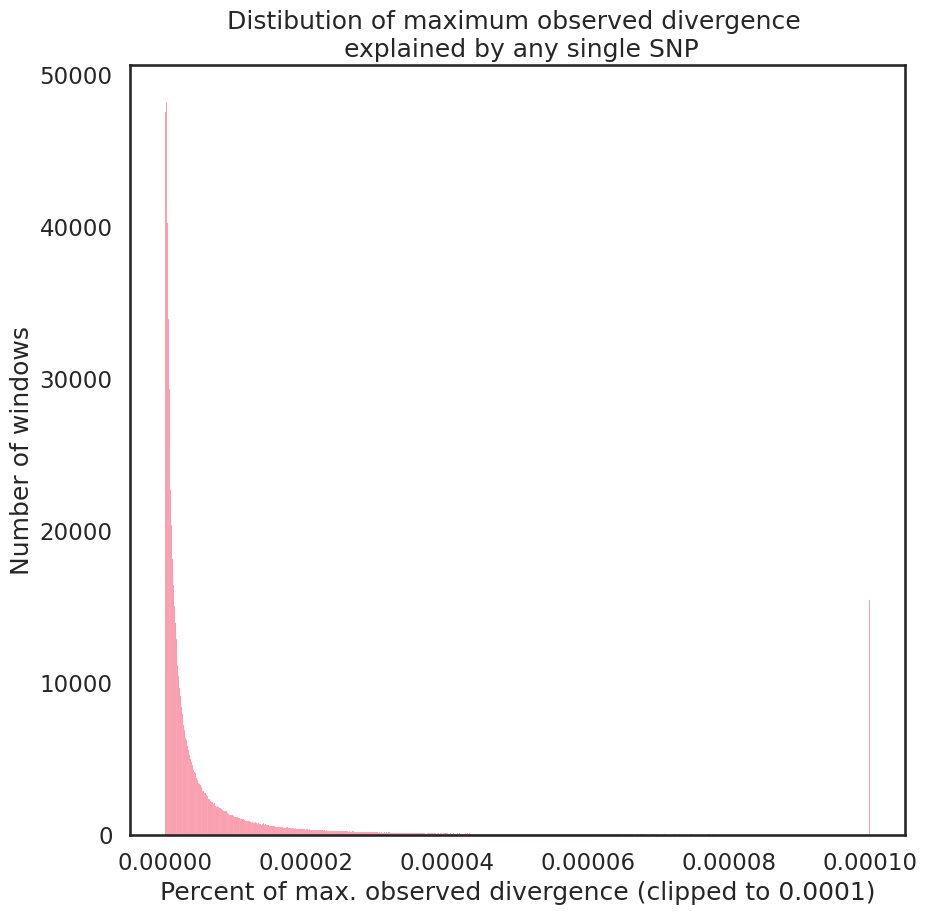

In [16]:
all_percs = np.array(all_percs).clip(0,.00010)

plt.figure(figsize=(10,10))
sns.histplot(all_percs)
plt.title('Distibution of maximum observed divergence \n explained by any single SNP')
plt.xlabel('Percent of max. observed divergence (clipped to 0.0001)')
plt.ylabel('Number of windows')

In [17]:
ism_dict.keys()

dict_keys([('chr1', 41418752), ('chr1', 57147392), ('chr1', 70778880), ('chr1', 88604672), ('chr1', 92798976), ('chr1', 96993280), ('chr1', 97517568), ('chr1', 106430464), ('chr1', 110100480), ('chr1', 120061952), ('chr1', 122683392), ('chr1', 123207680), ('chr1', 123731968), ('chr1', 147324928), ('chr1', 152043520), ('chr1', 152567808), ('chr1', 159907840), ('chr1', 160432128), ('chr1', 168820736), ('chr1', 169345024), ('chr1', 172490752), ('chr1', 176685056), ('chr1', 177209344), ('chr1', 187170816), ('chr1', 190316544), ('chr1', 192937984), ('chr1', 193462272), ('chr1', 193986560), ('chr1', 207093760), ('chr1', 246415360), ('chr2', 13107200), ('chr2', 13631488), ('chr2', 14680064), ('chr2', 17825792), ('chr2', 27262976), ('chr2', 27787264), ('chr2', 28835840), ('chr2', 35127296), ('chr2', 35651584), ('chr2', 44040192), ('chr2', 44564480), ('chr2', 48234496), ('chr2', 49807360), ('chr2', 50331648), ('chr2', 53477376), ('chr2', 57147392), ('chr2', 57671680), ('chr2', 70778880), ('chr2

In [18]:
emp

ttest_stat     ttest_pval  obs_mean  exp_mean   obs/exp  \
chr   windowStartPos                                                            
chr1  41418752        -26.987165  1.461871e-143  0.011143  0.003190  3.492743   
      57147392        -11.867927   9.060743e-32  0.021517  0.007885  2.728665   
      70778880         -5.334215   1.032114e-07  0.003761  0.002849  1.319976   
      88604672        -17.578602   7.272380e-66  0.014955  0.002522  5.929643   
      92798976        -16.384539   8.147811e-58  0.071182  0.008426  8.447434   
...                          ...            ...       ...       ...       ...   
chr21 35127296         -8.395653   7.093248e-17  0.030532  0.022997  1.327648   
chr22 22020096        -10.467888   3.332675e-25  0.023887  0.017606  1.356793   
      22544384         -9.387509   1.188089e-20  0.011776  0.007743  1.520958   
      47710208        -26.485256  7.297025e-139  0.055388  0.020211  2.740559   
      48234496        -55.442420   0.000000e+00  0.204145  0.035823  5.698711   

                       obs-exp   -log10(p) direction   sig  numWindowsAbove  \
chr   windowStartPos                                                          
chr1  41418752        0.007953  142.835091    higher  True                2   
      57147392        0.013631   31.042836    higher  True                1   
      70778880        0.000912    6.986272    higher  True                0   
      88604672        0.012433   65.138323    higher  True                7   
      92798976        0.062755   57.088959    higher  True                0   
...                        ...         ...       ...   ...              ...   
chr21 35127296        0.007535   16.149155    higher  True                0   
chr22 22020096        0.006282   24.477207    higher  True                0   
      22544384        0.004034   19.925151    higher  True                0   
      47710208        0.035178  138.136854    higher  True                0   
      48234496        0.168322         inf    higher  True              367   

                      ...       ALL       AFR       EUR       EAS       SAS  \
chr   windowStartPos  ...                                                     
chr1  41418752        ...  0.011143  0.010108  0.011830  0.013180  0.011994   
      57147392        ...  0.021517  0.009149  0.031168  0.016713  0.022907   
      70778880        ...  0.003761  0.003670  0.003780  0.003793  0.003737   
      88604672        ...  0.014955  0.007492  0.022346  0.014407  0.018429   
      92798976        ...  0.071182  0.062220  0.047517  0.096720  0.079656   
...                   ...       ...       ...       ...       ...       ...   
chr21 35127296        ...  0.030532  0.034489  0.028786  0.028111  0.029609   
chr22 22020096        ...  0.023887  0.027355  0.024776  0.021138  0.021943   
      22544384        ...  0.011776  0.015540  0.012083  0.008256  0.011551   
      47710208        ...  0.055388  0.055222  0.060998  0.053654  0.047932   
      48234496        ...  0.204145  0.204803  0.214279  0.197077  0.187644   

                           AMR       min       max   emp_min   emp_max  
chr   windowStartPos                                                    
chr1  41418752        0.008076  0.000214  0.061708  0.000240  0.047160  
      57147392        0.036207  0.000460  0.241914  0.000711  0.198873  
      70778880        0.003891  0.000125  0.015220  0.000125  0.071377  
      88604672        0.014783  0.000098  0.068938  0.000080  0.055810  
      92798976        0.074693  0.000381  0.260017  0.000371  0.454930  
...                        ...       ...       ...       ...       ...  
chr21 35127296        0.030236  0.008522  0.120146  0.001044  0.323117  
chr22 22020096        0.022474  0.001957  0.055087  0.001038  0.190579  
      22544384        0.009572  0.000380  0.032310  0.000370  0.141347  
      47710208        0.059584  0.001600  0.142327  0.001173  0.203276  
      48234496        0.219469  0.00

In [19]:
emp['max_ism_div'] = max_divs

In [20]:
emp['max_obs_div'] = anc_div.loc[emp.index].max(axis=1)
emp['med_obs_div'] = anc_div.loc[emp.index].median(axis=1)
#emp['max_obs_div'] = anc_div.loc[emp.index].max(axis=1)

Text(0.5, 1.0, 'Maximum 3D divergence per window')

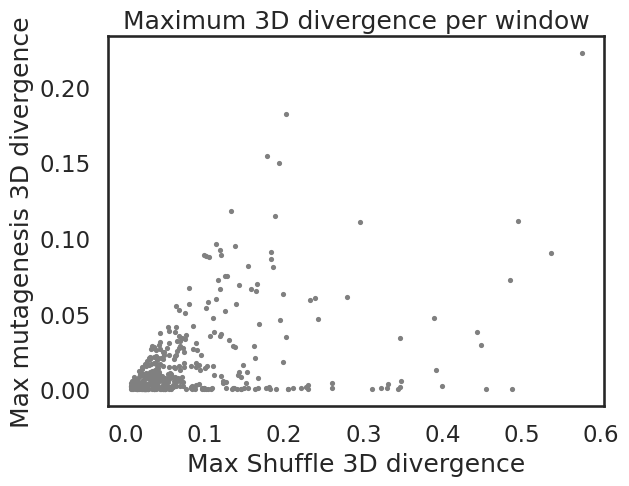

In [21]:
plt.scatter(emp['max_obs_div'], emp['max_ism_div'], s=5, color='grey')
plt.xlabel('Max Shuffle 3D divergence')
plt.ylabel('Max mutagenesis 3D divergence')
plt.title('Maximum 3D divergence per window')

Text(0.5, 1.0, 'Maximum 3D divergence per window')

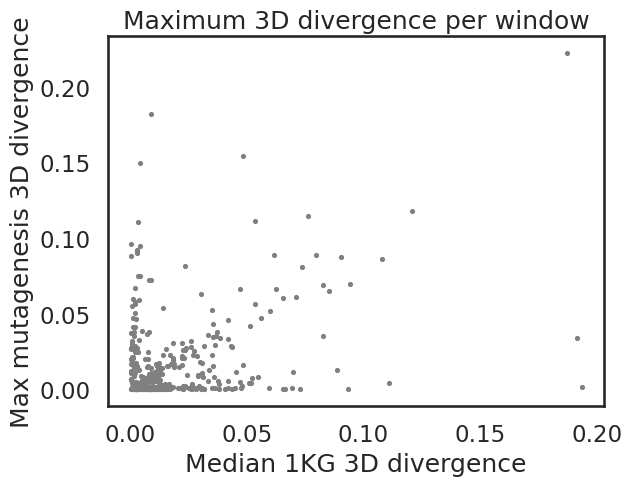

In [22]:
plt.scatter(emp['med_obs_div'], emp['max_ism_div'], s=5, color='grey')
plt.xlabel('Median 1KG 3D divergence')
plt.ylabel('Max mutagenesis 3D divergence')
plt.title('Maximum 3D divergence per window')

In [23]:
emp['percent_of_max'] = emp['max_ism_div'] / emp['max_obs_div']
emp['percent_of_med'] = emp['max_ism_div'] / emp['med_obs_div']

Text(0.5, 0, 'Percent of maximum observed divergence')

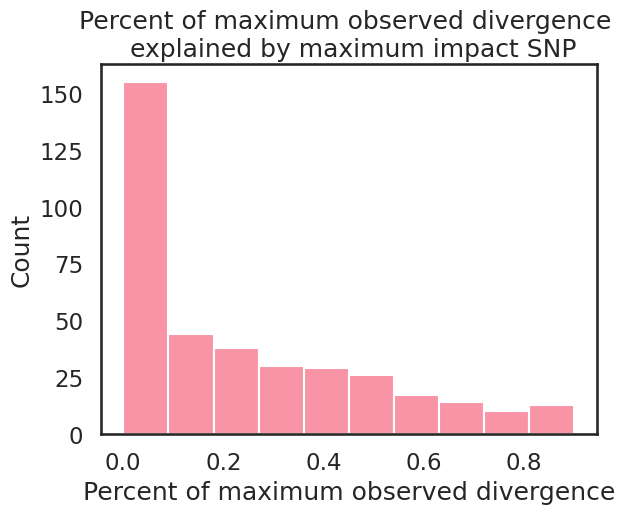

In [24]:
sns.histplot(emp['percent_of_max'])
plt.title('Percent of maximum observed divergence \n explained by maximum impact SNP')
plt.xlabel('Percent of maximum observed divergence')

Text(0.5, 1.0, 'x axis cut off at 2, (maximum is ~152)')

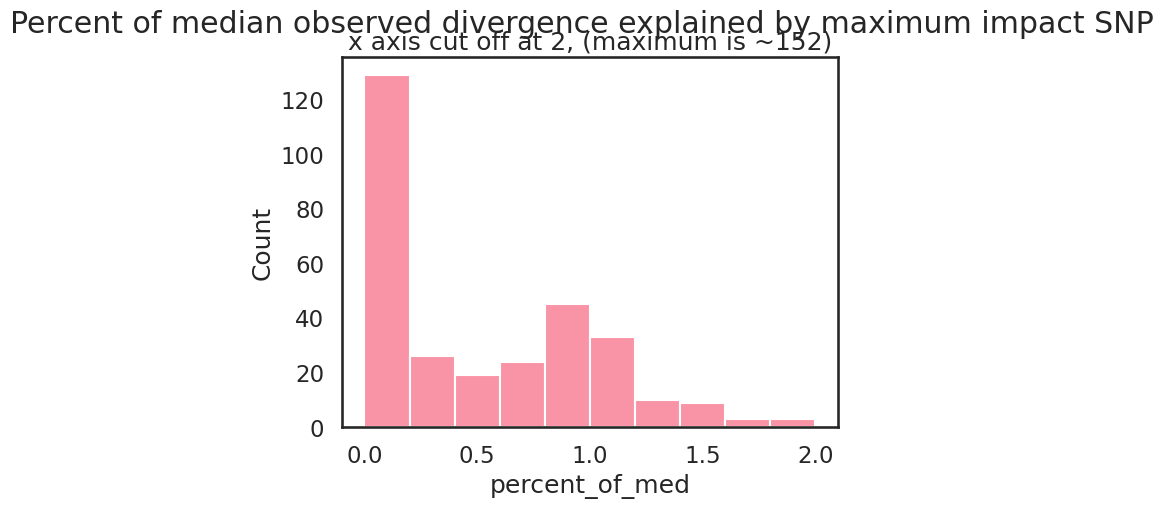

In [25]:
sns.histplot(emp['percent_of_med'], binrange=(0,2))
plt.suptitle('Percent of median observed divergence explained by maximum impact SNP')
plt.title('x axis cut off at 2, (maximum is ~152)')

In [37]:
emp.sort_values(by='max_ism_div', ascending=False)

ttest_stat     ttest_pval      obs_mean      exp_mean  \
chr   windowStartPos                                                          
chr7  125829120       -20.437908   6.091180e-87  1.205846e-01  1.491484e-02   
chr5  18350080         -9.039596   2.777394e-19  4.246237e-02  1.373628e-02   
chr2  35127296        -11.630032   1.333743e-30  5.238522e-02  2.436805e-02   
chr13 68681728         -5.261608   1.530183e-07  3.389068e-02  1.784575e-02   
chr10 96468992        -35.570247  5.990914e-231  9.083415e-02  7.102776e-03   
...                          ...            ...           ...           ...   
chr17 24117248        -41.280937  1.877199e-294  4.948939e-11  0.000000e+00   
chr18 17301504        -40.933797  1.648536e-290  8.030596e-11  0.000000e+00   
      19398656        -40.714949  4.995435e-288  5.817981e-11  0.000000e+00   
chr19 25165824        -41.497584  6.424500e-297  3.590249e-11  2.220446e-17   
      25690112        -41.489288  7.985836e-297  3.454752e-11  0.000000e+00   

                           obs/exp       obs-exp   -log10(p) direction   sig  \
chr   windowStartPos                                                           
chr7  125829120       8.084869e+00  1.056697e-01   86.215299    higher  True   
chr5  18350080        3.091258e+00  2.872609e-02   18.556363    higher  True   
chr2  35127296        2.149750e+00  2.801717e-02   29.874928    higher  True   
chr13 68681728        1.899089e+00  1.604493e-02    6.815257    higher  True   
chr10 96468992        1.278854e+01  8.373137e-02  230.222507    higher  True   
...                            ...           ...         ...       ...   ...   
chr17 24117248                 inf  4.948939e-11  293.726490    higher  True   
chr18 17301504                 inf  8.030596e-11  289.782901    higher  True   
      19398656                 inf  5.817981e-11  287.301427    higher  True   
chr19 25165824        1.616904e+06  3.590246e-11  296.192161    higher  True   
      25690112                 inf  3.454752e-11  296.097680    higher  True   

                      numWindowsAbove  ...           AMR       min  \
chr   windowStartPos                   ...                           
chr7  125829120                    19  ...  1.047728e-01  0.000669   
chr5  18350080                      0  ...  4.429541e-02  0.004546   
chr2  35127296                      0  ...  3.765436e-02  0.001160   
chr13 68681728                      0  ...  3.822095e-02  0.001357   
chr10 96468992                      0  ...  6.727453e-02  0.000326   
...                               ...  ...           ...       ...   
chr17 24117248                   1903  ...  5.163030e-11  0.000000   
chr18 17301504                   1903  ...  8.318346e-11  0.000000   
      19398656                   1903  ...  6.039959e-11  0.000000   
chr19 25165824                   1903  ...  3.720297e-11  0.000000   
      25690112                   1903  ...  3.584570e-11  0.000000   

                               max   emp_min       emp_max  max_ism_div  \
chr   windowStartPos                                                      
chr7  125829120       5.752178e-01  0.000000  5.091931e-01     0.222205   
chr5  18350080        2.019340e-01  0.000672  3.625176e-01     0.181841   
chr2  35127296        1.787666e-01  0.000737  2.405862e-01     0.154261   
chr13 68681728        1.934238e-01  0.000358  5.014548e-01     0.149404   
chr10 96468992        1.323995e-01  0.000313  1.339358e-01     0.118073   
...                            ...       ...           ...          ...   
chr17 24117248        6.748357e-11  0.000000  0.000000e+00          NaN   
chr18 17301504        1.058902e-10  0.000000  0.000000e+00          NaN   
      19398656        7.786360e-11  0.000000  0.000000e+00          NaN   
chr19 25165824        4.670242e-11  0.000000  1.110223e-16          NaN   
      25690112        4.511558e-11  0.000000  0.000000e+00          NaN   

                       max_obs_div   med_obs_div  percent_of_max  

In [33]:
ism[ism.chr=='chr5'][ism.window==18350080].sort_values(by='1-spearman', ascending=False)

/scratch/egilbertson/ipykernel_18512/93828037.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ism[ism.chr=='chr5'][ism.window==18350080].sort_values(by='1-spearman', ascending=False)


,chr,pos,window,ref,alt,mse,1-pearson,1-spearman
559986,chr5,18466287,18350080,G,A,6.451819e-03,1.760998e-01,1.818409e-01
559988,chr5,18466291,18350080,C,T,3.076718e-04,8.274816e-03,7.123966e-03
560898,chr5,18698753,18350080,G,A,5.899011e-05,1.091199e-03,9.489403e-04
561939,chr5,19073830,18350080,C,T,1.150433e-05,2.995418e-04,3.063073e-04
561112,chr5,18772502,18350080,G,A,8.076083e-06,1.763061e-04,1.642567e-04
...,...,...,...,...,...,...,...,...
562762,chr5,19393553,18350080,A,T,3.002246e-11,8.051692e-10,1.555161e-09
559168,chr5,18350702,18350080,T,C,3.115424e-11,8.280647e-10,1.359380e-09
559226,chr5,18353689,18350080,T,G,2.317990e-11,6.438458e-10,1.225000e-09
559178,chr5,18351494,18350080,A,T,2.383351e-11,6.385528e-10,1.150640e-09


In [35]:
ism[ism.chr=='chr7'][ism.window==125829120].sort_values(by='1-spearman', ascending=False)

/scratch/egilbertson/ipykernel_18512/3714539931.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ism[ism.chr=='chr7'][ism.window==125829120].sort_values(by='1-spearman', ascending=False)


,chr,pos,window,ref,alt,mse,1-pearson,1-spearman
673005,chr7,126645389,125829120,C,T,4.075127e-03,2.227842e-01,2.222050e-01
671745,chr7,126380660,125829120,T,C,1.053948e-04,4.610999e-03,6.877434e-03
671987,chr7,126429689,125829120,G,A,3.524182e-06,1.881530e-04,2.562810e-04
671741,chr7,126380533,125829120,T,C,3.946468e-06,1.827399e-04,2.519270e-04
671973,chr7,126426824,125829120,A,G,3.005384e-06,1.659801e-04,2.311829e-04
...,...,...,...,...,...,...,...,...
670430,chr7,125837435,125829120,C,T,4.152158e-11,2.068876e-09,3.385562e-09
670500,chr7,125861769,125829120,C,T,2.736654e-11,1.395125e-09,2.801691e-09
673813,chr7,126868435,125829120,G,A,5.813134e-11,2.960177e-09,2.678045e-09
673817,chr7,126871966,125829120,T,C,2.970402e-11,1.446840e-09,2.120656e-09


## Additive effects

In [158]:
ism_dict[('chr1',
  41418752)]['1-spearman'].sum()

0.015445614110028547

In [156]:
emp

ttest_stat     ttest_pval  obs_mean  exp_mean   obs/exp  \
chr   windowStartPos                                                            
chr1  41418752        -26.987165  1.461871e-143  0.011143  0.003190  3.492743   
      57147392        -11.867927   9.060743e-32  0.021517  0.007885  2.728665   
      70778880         -5.334215   1.032114e-07  0.003761  0.002849  1.319976   
      88604672        -17.578602   7.272380e-66  0.014955  0.002522  5.929643   
      92798976        -16.384539   8.147811e-58  0.071182  0.008426  8.447434   
...                          ...            ...       ...       ...       ...   
chr21 35127296         -8.395653   7.093248e-17  0.030532  0.022997  1.327648   
chr22 22020096        -10.467888   3.332675e-25  0.023887  0.017606  1.356793   
      22544384         -9.387509   1.188089e-20  0.011776  0.007743  1.520958   
      47710208        -26.485256  7.297025e-139  0.055388  0.020211  2.740559   
      48234496        -55.442420   0.000000e+00  0.204145  0.035823  5.698711   

                       obs-exp   -log10(p) direction   sig  numWindowsAbove  \
chr   windowStartPos                                                          
chr1  41418752        0.007953  142.835091    higher  True                2   
      57147392        0.013631   31.042836    higher  True                1   
      70778880        0.000912    6.986272    higher  True                0   
      88604672        0.012433   65.138323    higher  True                7   
      92798976        0.062755   57.088959    higher  True                0   
...                        ...         ...       ...   ...              ...   
chr21 35127296        0.007535   16.149155    higher  True                0   
chr22 22020096        0.006282   24.477207    higher  True                0   
      22544384        0.004034   19.925151    higher  True                0   
      47710208        0.035178  138.136854    higher  True                0   
      48234496        0.168322         inf    higher  True              367   

                      ...       AMR       min       max   emp_min   emp_max  \
chr   windowStartPos  ...                                                     
chr1  41418752        ...  0.008076  0.000214  0.061708  0.000240  0.047160   
      57147392        ...  0.036207  0.000460  0.241914  0.000711  0.198873   
      70778880        ...  0.003891  0.000125  0.015220  0.000125  0.071377   
      88604672        ...  0.014783  0.000098  0.068938  0.000080  0.055810   
      92798976        ...  0.074693  0.000381  0.260017  0.000371  0.454930   
...                   ...       ...       ...       ...       ...       ...   
chr21 35127296        ...  0.030236  0.008522  0.120146  0.001044  0.323117   
chr22 22020096        ...  0.022474  0.001957  0.055087  0.001038  0.190579   
      22544384        ...  0.009572  0.000380  0.032310  0.000370  0.141347   
      47710208        ...  0.059584  0.001600  0.142327  0.001173  0.203276   
      48234496        ...  0.219469  0.002814  0.346398  0.002023  0.280502   

                      max_ism_div  max_obs_div  med_obs_div  percent_of_max  \
chr   windowStartPos                                                          
chr1  41418752           0.013818     0.061708     0.013622        0.223924   
      57147392           0.046179     0.241914     0.002589        0.190889   
      70778880           0.004463     0.015220     0.003781        0.293259   
      88604672           0.028706     0.068938     0.000810        0.416400   
      92798976           0.000728     0.260017     0.001733        0.002798   
...                           ...          ...          ...             ...   
chr21 35127296           0.008852     0.120146     0.029215        0.073674   
chr22 22020096           0.009399     0.055087     0.024408        0.170624   
      22544384           0.006354     0.032310     0.012853        0.196670   
      47710208           0.011125     0.142

In [159]:
additive = []
for w in ism_dict.keys():
    additive.append(ism_dict[w]['1-spearman'].sum())

In [162]:
emp['ism_sum'] = additive

In [164]:
emp['additive_percent_of_max'] = emp['ism_sum'] / emp['max_obs_div']

Text(0.5, 0, 'Percent of maximum observed divergence')

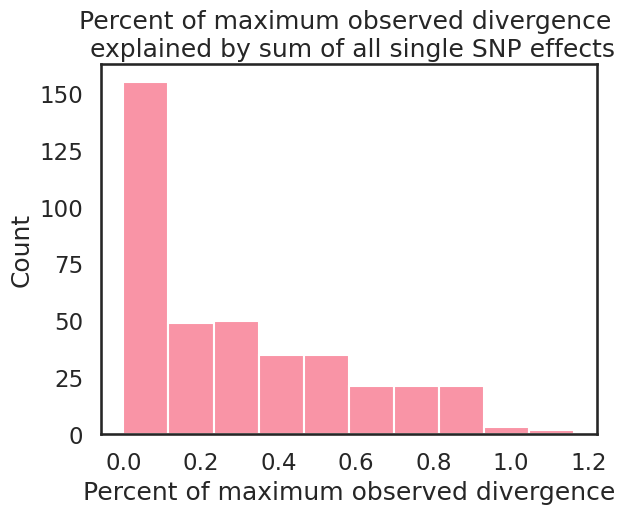

In [184]:
sns.histplot(emp['additive_percent_of_max'])
plt.title('Percent of maximum observed divergence \n explained by sum of all single SNP effects')
plt.xlabel('Percent of maximum observed divergence')

## Annotate 3D disrupting variants

### ID disrupting variants

In [172]:
emp

ttest_stat     ttest_pval  obs_mean  exp_mean   obs/exp  \
chr   windowStartPos                                                            
chr1  41418752        -26.987165  1.461871e-143  0.011143  0.003190  3.492743   
      57147392        -11.867927   9.060743e-32  0.021517  0.007885  2.728665   
      70778880         -5.334215   1.032114e-07  0.003761  0.002849  1.319976   
      88604672        -17.578602   7.272380e-66  0.014955  0.002522  5.929643   
      92798976        -16.384539   8.147811e-58  0.071182  0.008426  8.447434   
...                          ...            ...       ...       ...       ...   
chr21 35127296         -8.395653   7.093248e-17  0.030532  0.022997  1.327648   
chr22 22020096        -10.467888   3.332675e-25  0.023887  0.017606  1.356793   
      22544384         -9.387509   1.188089e-20  0.011776  0.007743  1.520958   
      47710208        -26.485256  7.297025e-139  0.055388  0.020211  2.740559   
      48234496        -55.442420   0.000000e+00  0.204145  0.035823  5.698711   

                       obs-exp   -log10(p) direction   sig  numWindowsAbove  \
chr   windowStartPos                                                          
chr1  41418752        0.007953  142.835091    higher  True                2   
      57147392        0.013631   31.042836    higher  True                1   
      70778880        0.000912    6.986272    higher  True                0   
      88604672        0.012433   65.138323    higher  True                7   
      92798976        0.062755   57.088959    higher  True                0   
...                        ...         ...       ...   ...              ...   
chr21 35127296        0.007535   16.149155    higher  True                0   
chr22 22020096        0.006282   24.477207    higher  True                0   
      22544384        0.004034   19.925151    higher  True                0   
      47710208        0.035178  138.136854    higher  True                0   
      48234496        0.168322         inf    higher  True              367   

                      ...       AMR       min       max   emp_min   emp_max  \
chr   windowStartPos  ...                                                     
chr1  41418752        ...  0.008076  0.000214  0.061708  0.000240  0.047160   
      57147392        ...  0.036207  0.000460  0.241914  0.000711  0.198873   
      70778880        ...  0.003891  0.000125  0.015220  0.000125  0.071377   
      88604672        ...  0.014783  0.000098  0.068938  0.000080  0.055810   
      92798976        ...  0.074693  0.000381  0.260017  0.000371  0.454930   
...                   ...       ...       ...       ...       ...       ...   
chr21 35127296        ...  0.030236  0.008522  0.120146  0.001044  0.323117   
chr22 22020096        ...  0.022474  0.001957  0.055087  0.001038  0.190579   
      22544384        ...  0.009572  0.000380  0.032310  0.000370  0.141347   
      47710208        ...  0.059584  0.001600  0.142327  0.001173  0.203276   
      48234496        ...  0.219469  0.002814  0.346398  0.002023  0.280502   

                      max_ism_div  max_obs_div  med_obs_div  percent_of_max  \
chr   windowStartPos                                                          
chr1  41418752           0.013818     0.061708     0.013622        0.223924   
      57147392           0.046179     0.241914     0.002589        0.190889   
      70778880           0.004463     0.015220     0.003781        0.293259   
      88604672           0.028706     0.068938     0.000810        0.416400   
      92798976           0.000728     0.260017     0.001733        0.002798   
...                           ...          ...          ...             ...   
chr21 35127296           0.008852     0.120146     0.029215        0.073674   
chr22 22020096           0.009399     0.055087     0.024408        0.170624   
      22544384           0.006354     0.032310     0.012853        0.196670   
      47710208           0.011125     0.142

In [173]:
ism_dict[('chr1',
  41418752)]

,chr,pos,window,ref,alt,mse,1-pearson,1-spearman,percent_of_max_observed
0,chr1,41419194,41418752,G,A,4.010169e-10,1.528952e-09,2.227691e-09,3.610057e-08
1,chr1,41419903,41418752,T,A,6.424570e-10,2.430540e-09,4.395940e-09,7.123786e-08
2,chr1,41419982,41418752,G,A,2.975184e-10,9.618393e-10,2.712017e-09,4.394926e-08
3,chr1,41420026,41418752,T,C,1.394818e-10,4.707098e-10,1.339220e-09,2.170256e-08
4,chr1,41421729,41418752,G,A,1.894821e-10,7.112624e-10,1.574174e-09,2.551008e-08
...,...,...,...,...,...,...,...,...,...
1741,chr1,42465654,41418752,G,T,2.755102e-10,1.058228e-09,1.286805e-09,2.085315e-08
1742,chr1,42465656,41418752,C,T,1.067920e-10,4.187068e-10,7.180145e-10,1.163570e-08
1743,chr1,42465863,41418752,A,G,2.016804e-10,6.311963e-10,9.683133e-10,1.569188e-08
1744,chr1,42466665,41418752,C,T,8.591350e-10,3.369644e-09,4.139793e-09,6.708690e-08


In [174]:
w = ('chr1',
  41418752)

In [175]:
emp

ttest_stat     ttest_pval  obs_mean  exp_mean   obs/exp  \
chr   windowStartPos                                                            
chr1  41418752        -26.987165  1.461871e-143  0.011143  0.003190  3.492743   
      57147392        -11.867927   9.060743e-32  0.021517  0.007885  2.728665   
      70778880         -5.334215   1.032114e-07  0.003761  0.002849  1.319976   
      88604672        -17.578602   7.272380e-66  0.014955  0.002522  5.929643   
      92798976        -16.384539   8.147811e-58  0.071182  0.008426  8.447434   
...                          ...            ...       ...       ...       ...   
chr21 35127296         -8.395653   7.093248e-17  0.030532  0.022997  1.327648   
chr22 22020096        -10.467888   3.332675e-25  0.023887  0.017606  1.356793   
      22544384         -9.387509   1.188089e-20  0.011776  0.007743  1.520958   
      47710208        -26.485256  7.297025e-139  0.055388  0.020211  2.740559   
      48234496        -55.442420   0.000000e+00  0.204145  0.035823  5.698711   

                       obs-exp   -log10(p) direction   sig  numWindowsAbove  \
chr   windowStartPos                                                          
chr1  41418752        0.007953  142.835091    higher  True                2   
      57147392        0.013631   31.042836    higher  True                1   
      70778880        0.000912    6.986272    higher  True                0   
      88604672        0.012433   65.138323    higher  True                7   
      92798976        0.062755   57.088959    higher  True                0   
...                        ...         ...       ...   ...              ...   
chr21 35127296        0.007535   16.149155    higher  True                0   
chr22 22020096        0.006282   24.477207    higher  True                0   
      22544384        0.004034   19.925151    higher  True                0   
      47710208        0.035178  138.136854    higher  True                0   
      48234496        0.168322         inf    higher  True              367   

                      ...       AMR       min       max   emp_min   emp_max  \
chr   windowStartPos  ...                                                     
chr1  41418752        ...  0.008076  0.000214  0.061708  0.000240  0.047160   
      57147392        ...  0.036207  0.000460  0.241914  0.000711  0.198873   
      70778880        ...  0.003891  0.000125  0.015220  0.000125  0.071377   
      88604672        ...  0.014783  0.000098  0.068938  0.000080  0.055810   
      92798976        ...  0.074693  0.000381  0.260017  0.000371  0.454930   
...                   ...       ...       ...       ...       ...       ...   
chr21 35127296        ...  0.030236  0.008522  0.120146  0.001044  0.323117   
chr22 22020096        ...  0.022474  0.001957  0.055087  0.001038  0.190579   
      22544384        ...  0.009572  0.000380  0.032310  0.000370  0.141347   
      47710208        ...  0.059584  0.001600  0.142327  0.001173  0.203276   
      48234496        ...  0.219469  0.002814  0.346398  0.002023  0.280502   

                      max_ism_div  max_obs_div  med_obs_div  percent_of_max  \
chr   windowStartPos                                                          
chr1  41418752           0.013818     0.061708     0.013622        0.223924   
      57147392           0.046179     0.241914     0.002589        0.190889   
      70778880           0.004463     0.015220     0.003781        0.293259   
      88604672           0.028706     0.068938     0.000810        0.416400   
      92798976           0.000728     0.260017     0.001733        0.002798   
...                           ...          ...          ...             ...   
chr21 35127296           0.008852     0.120146     0.029215        0.073674   
chr22 22020096           0.009399     0.055087     0.024408        0.170624   
      22544384           0.006354     0.032310     0.012853        0.196670   
      47710208           0.011125     0.142

In [176]:
ism

,chr,pos,window,ref,alt,mse,1-pearson,1-spearman
0,chr1,41419194,41418752,G,A,4.010169e-10,1.528952e-09,2.227691e-09
1,chr1,41419903,41418752,T,A,6.424570e-10,2.430540e-09,4.395940e-09
2,chr1,41419982,41418752,G,A,2.975184e-10,9.618393e-10,2.712017e-09
3,chr1,41420026,41418752,T,C,1.394818e-10,4.707098e-10,1.339220e-09
4,chr1,41421729,41418752,G,A,1.894821e-10,7.112624e-10,1.574174e-09
...,...,...,...,...,...,...,...,...
721717,chr9,125819519,124780544,C,G,6.015042e-09,1.393339e-08,1.644450e-08
721718,chr9,125821620,124780544,G,A,2.798776e-09,6.660611e-09,1.031697e-08
721719,chr9,125824208,124780544,A,T,2.335459e-10,5.788691e-10,1.391949e-09
721720,chr9,125824786,124780544,C,T,2.315557e-09,5.479565e-09,6.564956e-09


In [177]:
# ism variant is more disruptive than median observed individual divergence
mod_vars = pd.DataFrame(columns = ism.columns)
for w in ism_dict.keys():
    df = ism_dict[w]
    em = emp.loc[w].med_obs_div
    df = df[df['1-spearman'] > em]
    if df.shape[0] != 0:
        mod_vars = pd.concat([mod_vars, df])
mod_vars

,chr,pos,window,ref,alt,mse,1-pearson,1-spearman,percent_of_max_observed
934,chr1,41924264,41418752,G,A,0.002050,0.007383,0.013818,0.223924
3169,chr1,57835819,57147392,G,C,0.001049,0.032333,0.046179,0.190889
4891,chr1,71588165,70778880,G,C,0.000709,0.001443,0.004463,0.293259
6013,chr1,89085986,88604672,G,C,0.012915,0.018012,0.028706,0.416400
41997,chr1,207692807,207093760,T,G,0.001659,0.011808,0.014019,0.346031
...,...,...,...,...,...,...,...,...,...
407524,chr20,53099036,52428800,C,T,0.001304,0.060778,0.056723,0.714326
413921,chr21,19735128,19398656,T,A,0.001202,0.052344,0.081342,0.527366
418169,chr21,21751496,20971520,A,G,0.002042,0.028540,0.058876,0.253647
418170,chr21,21751496,21495808,A,G,0.001653,0.062862,0.072187,0.148892


In [178]:
mod_vars = pd.DataFrame(columns = ism.columns)
for w in ism_dict.keys():
    df = ism_dict[w]
    df = df[df['percent_of_max_observed'] > .5]
    if df.shape[0] != 0:
        mod_vars = pd.concat([mod_vars, df])
mod_vars

,chr,pos,window,ref,alt,mse,1-pearson,1-spearman,percent_of_max_observed
309441,chr2,18178938,17825792,C,T,0.005557,0.014375,0.016556,0.677029
312189,chr2,28155815,27262976,C,T,0.009965,0.017268,0.026854,0.830247
312190,chr2,28155815,27787264,C,T,0.019031,0.053049,0.096345,0.848726
319313,chr2,35858407,35127296,A,G,0.010148,0.169487,0.154261,0.862917
319314,chr2,35858407,35651584,A,G,0.007491,0.054273,0.058001,0.557110
...,...,...,...,...,...,...,...,...,...
395166,chr20,12661100,12058624,A,T,0.001295,0.008427,0.027543,0.529449
400472,chr20,38790643,38273024,C,T,0.019338,0.046760,0.053516,0.530156
402077,chr20,41572207,40894464,G,C,0.008765,0.026429,0.029039,0.684638
407524,chr20,53099036,52428800,C,T,0.001304,0.060778,0.056723,0.714326


In [182]:
mod_vars = pd.DataFrame(columns = ism.columns)
for w in ism_dict.keys():
    df = ism_dict[w]
    df = df[df['percent_of_max_observed'] > .2]
    if df.shape[0] != 0:
        mod_vars = pd.concat([mod_vars, df])
mod_vars

,chr,pos,window,ref,alt,mse,1-pearson,1-spearman,percent_of_max_observed
934,chr1,41924264,41418752,G,A,0.002050,0.007383,0.013818,0.223924
4891,chr1,71588165,70778880,G,C,0.000709,0.001443,0.004463,0.293259
6013,chr1,89085986,88604672,G,C,0.012915,0.018012,0.028706,0.416400
10056,chr1,97870773,96993280,G,A,0.000861,0.013771,0.016971,0.391997
10057,chr1,97870773,97517568,G,A,0.001004,0.008537,0.010392,0.333523
...,...,...,...,...,...,...,...,...,...
402077,chr20,41572207,40894464,G,C,0.008765,0.026429,0.029039,0.684638
407524,chr20,53099036,52428800,C,T,0.001304,0.060778,0.056723,0.714326
413921,chr21,19735128,19398656,T,A,0.001202,0.052344,0.081342,0.527366
418169,chr21,21751496,20971520,A,G,0.002042,0.028540,0.058876,0.253647


In [183]:
mod_vars['pos+1'] = mod_vars['pos'] +1
mod_vars = mod_vars[['chr','pos', 'pos+1','window','ref','alt','percent_of_max_observed', '1-spearman']]

In [184]:
mod_vars

,chr,pos,pos+1,window,ref,alt,percent_of_max_observed,1-spearman
934,chr1,41924264,41924265,41418752,G,A,0.223924,0.013818
4891,chr1,71588165,71588166,70778880,G,C,0.293259,0.004463
6013,chr1,89085986,89085987,88604672,G,C,0.416400,0.028706
10056,chr1,97870773,97870774,96993280,G,A,0.391997,0.016971
10057,chr1,97870773,97870774,97517568,G,A,0.333523,0.010392
...,...,...,...,...,...,...,...,...
402077,chr20,41572207,41572208,40894464,G,C,0.684638,0.029039
407524,chr20,53099036,53099037,52428800,C,T,0.714326,0.056723
413921,chr21,19735128,19735129,19398656,T,A,0.527366,0.081342
418169,chr21,21751496,21751497,20971520,A,G,0.253647,0.058876


Text(0.5, 1.0, 'Distribution of 3D divergence caused by modifying variants')

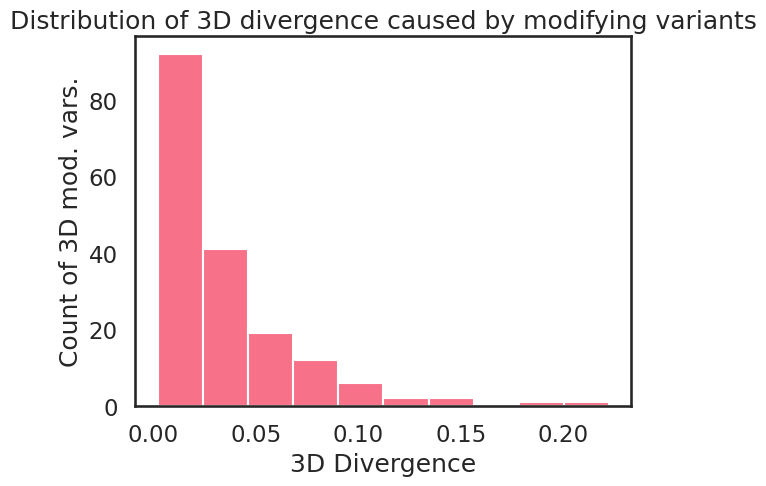

In [186]:
plt.hist(mod_vars['1-spearman'])
plt.xlabel('3D Divergence')
plt.ylabel('Count of 3D mod. vars.')
plt.title('Distribution of 3D divergence caused by modifying variants')

Text(0.5, 1.0, 'Distribution of 3D divergence caused by all common variants')

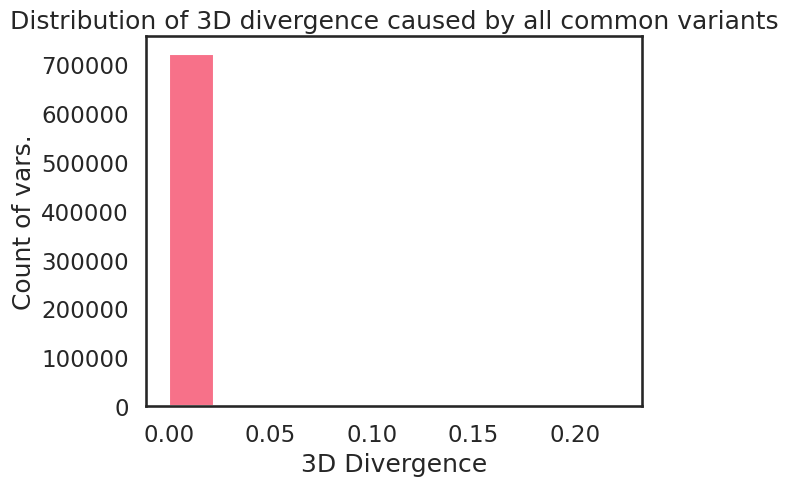

In [191]:
plt.hist(ism['1-spearman'])
plt.xlabel('3D Divergence')
plt.ylabel('Count of vars.')
plt.title('Distribution of 3D divergence caused by all common variants')

Text(0.5, 1.0, 'Distribution of 3D divergence caused by of variants > 0.02 divergence')

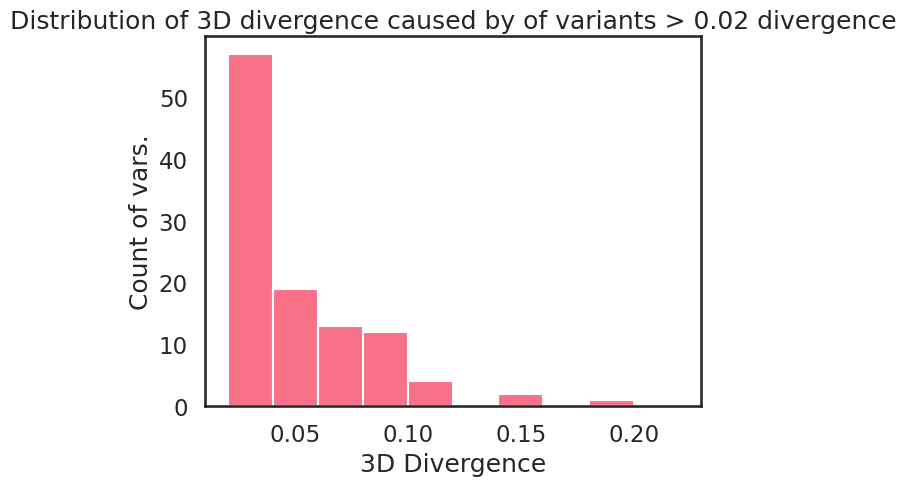

In [193]:
plt.hist(ism[ism['1-spearman'] > 0.02]['1-spearman'], range = (0.02, 0.22))
plt.xlabel('3D Divergence')
plt.ylabel('Count of vars.')
plt.title('Distribution of 3D divergence caused by of variants > 0.02 divergence')

### genomic annotations

In [83]:
ctcf = pybedtools.BedTool('%s/annotations/ctcf_full_merged.bed' % DATA_PATH).merge()
genes = pybedtools.BedTool('%s/annotations/grch38_gene_annotations.bed' % DATA_PATH)

In [111]:
mod_vars_annot = BedTool.from_dataframe(mod_vars).intersect(ctcf, wao=True).to_dataframe(disable_auto_names=True, header=None)
mod_vars_annot.columns = list(mod_vars.columns) + ['elem_chr','elem_start','elem_stop','ctcf']
mod_vars_annot = mod_vars_annot[list(mod_vars.columns) + ['ctcf']]

mod_vars_annot = BedTool.from_dataframe(mod_vars_annot).intersect(genes, wao=True).to_dataframe(disable_auto_names=True, header=None)
mod_vars_annot.columns = list(mod_vars.columns) + ['ctcf'] + ['elem_chr','elem_start','elem_stop','gene_name','genes']
mod_vars_annot = mod_vars_annot[list(mod_vars.columns) + ['ctcf', 'gene_name','genes']]
mod_vars_annot = mod_vars_annot.drop_duplicates(subset = list(mod_vars.columns), ignore_index=True)

phylop=pd.read_table('phylop.txt')
mod_vars_annot['phylop'] = phylop['Mean']


Text(0.5, 1.0, 'PhyloP Score distribution for 3D modifying SNPs')

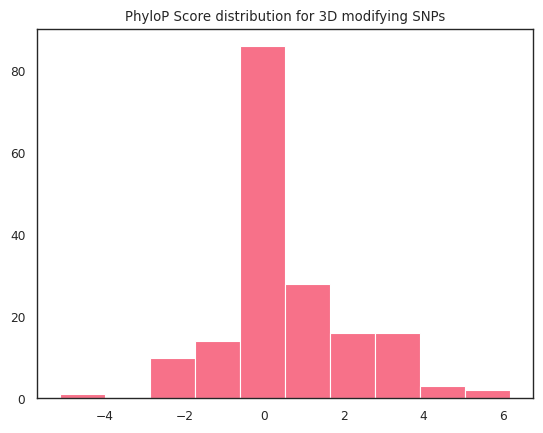

In [152]:
plt.hist(mod_vars_annot['phylop'])
plt.title('PhyloP Score distribution for 3D modifying SNPs')

In [121]:
mod_vars_annot[mod_vars_annot.ctcf==1].shape

(17, 11)

In [126]:
mod_vars_annot[mod_vars_annot.phylop>0]

,chr,pos,pos+1,window,ref,alt,percent_of_max_observed,ctcf,gene_name,genes,phylop
0,chr1,41924264,41924265,41418752,G,A,0.223924,0,.,0,0.387512
1,chr1,71588165,71588166,70778880,G,C,0.293259,0,NEGR1,1,2.035560
2,chr1,89085986,89085987,88604672,G,C,0.416400,0,.,0,0.225583
3,chr1,97870773,97870774,96993280,G,A,0.391997,0,DPYD,1,6.199230
4,chr1,97870773,97870774,97517568,G,A,0.333523,0,DPYD,1,6.199230
...,...,...,...,...,...,...,...,...,...,...,...
168,chr20,12661100,12661101,12582912,A,T,0.240413,0,.,0,0.108244
169,chr20,35145275,35145276,34603008,T,C,0.424265,0,EDEM2,1,0.802858
170,chr20,38790643,38790644,38273024,C,T,0.530156,0,.,0,0.944268
171,chr20,41572207,41572208,40894464,G,C,0.684638,0,CHD6,1,1.619590


In [127]:
mod_vars_annot[mod_vars_annot.phylop<0]

,chr,pos,pos+1,window,ref,alt,percent_of_max_observed,ctcf,gene_name,genes,phylop
10,chr2,13845356,13845357,13107200,T,G,0.236353,0,.,0,-0.635118
11,chr2,13845356,13845357,13631488,T,G,0.426936,0,.,0,-0.635118
12,chr2,15226104,15226105,14680064,G,C,0.395750,0,NBAS,1,-0.109669
16,chr2,35634697,35634698,35127296,T,C,0.267824,0,.,0,-0.539118
17,chr2,35858407,35858408,35127296,A,G,0.862917,0,.,0,-0.300252
...,...,...,...,...,...,...,...,...,...,...,...
164,chr20,3313837,3313838,2621440,C,T,0.411045,0,C20orf194,1,-0.401669
165,chr20,3313837,3313838,3145728,C,T,0.583223,0,C20orf194,1,-0.401669
172,chr20,53099036,53099037,52428800,C,T,0.714326,0,TSHZ2,1,-0.038354
174,chr21,21751496,21751497,20971520,A,G,0.253647,0,.,0,-0.011937


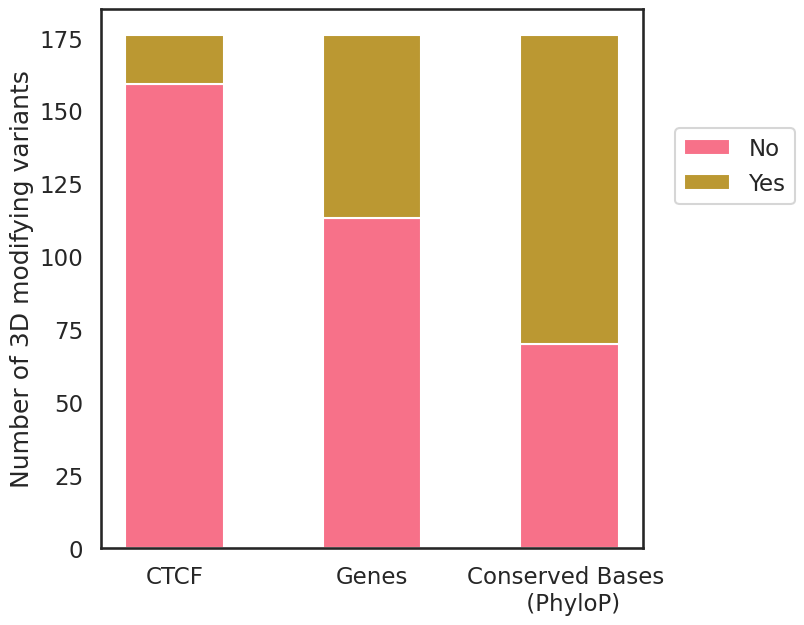

In [229]:
annots = ['CTCF','Genes', 'Conserved Bases \n (PhyloP)']
#1 = conserved phylop> 0 , 0 = fast evolving, phylop<0
annot_counts = {'No':[159, 113,70 ], 'Yes': [17,63, 106]}

width = 0.5

fig, ax = plt.subplots(figsize=(7,7))
bottom = np.zeros(3)

for boolean, annot_counts in annot_counts.items():
    p = ax.bar(annots, annot_counts, width, label=boolean, bottom=bottom)
    bottom += annot_counts

plt.ylabel('Number of 3D modifying variants')
ax.legend(loc="best", bbox_to_anchor=(.8, 0., 0.5, 0.8))

plt.show()

In [189]:
mod_vars_annot

,chr,pos,pos+1,window,ref,alt,percent_of_max_observed,ctcf,gene_name,genes,phylop
0,chr1,41924264,41924265,41418752,G,A,0.223924,0,.,0,0.387512
1,chr1,71588165,71588166,70778880,G,C,0.293259,0,NEGR1,1,2.035560
2,chr1,89085986,89085987,88604672,G,C,0.416400,0,.,0,0.225583
3,chr1,97870773,97870774,96993280,G,A,0.391997,0,DPYD,1,6.199230
4,chr1,97870773,97870774,97517568,G,A,0.333523,0,DPYD,1,6.199230
...,...,...,...,...,...,...,...,...,...,...,...
171,chr20,41572207,41572208,40894464,G,C,0.684638,0,CHD6,1,1.619590
172,chr20,53099036,53099037,52428800,C,T,0.714326,0,TSHZ2,1,-0.038354
173,chr21,19735128,19735129,19398656,T,A,0.527366,0,.,0,0.415480
174,chr21,21751496,21751497,20971520,A,G,0.253647,0,.,0,-0.011937


<AxesSubplot: xlabel='percent_of_max_observed', ylabel='ctcf'>

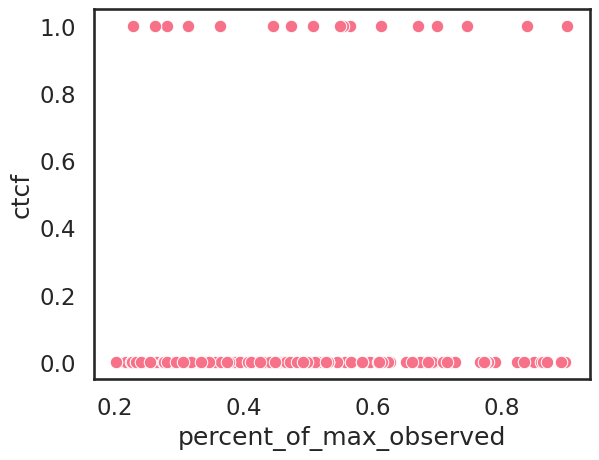

In [190]:
sns.scatterplot(x='percent_of_max_observed',y = 'ctcf', data = mod_vars_annot)

In [216]:
def PercentileToQuantile(x, bins):
    numQuants = bins
    quantSize = 1/numQuants
    currentQuant = quantSize
    currentReturn = 1
    numDecs = int(str(quantSize)[::-1].find('.'))
    for i in range(numQuants):
        if x < currentQuant:
            return currentReturn
        elif x == 1:
            return numQuants
        else:
            currentQuant = round((currentQuant + quantSize), numDecs)
            currentReturn += 1


def QuantAnnotate(distStat_df, annot_data, annot_type, quant_bins, metric):
    regions = distStat_df.copy(deep=True)
    regions['divergence_percentile'] = regions[metric].rank(pct=True)
    regions = regions.reset_index()
    regions['divergence_percentile_group'] = regions['divergence_percentile'].apply(PercentileToQuantile, bins=quant_bins)
    regions['stop'] = regions['pos'] + 2**20
    regions = regions[['chr','pos','stop',metric,'divergence_percentile','divergence_percentile_group']]
    regions.columns = ['chr','start','stop'] + list(regions.columns)[3:]
    region_list = regions[['chr','start','stop', 'divergence_percentile_group',metric]]

    if annot_type == 'genes':
        annotation = BedTool.from_dataframe(regions).intersect(annot_data, wo=True).to_dataframe(disable_auto_names=True, header=None)
        annotation.columns = list(regions.columns) + ['elem_chr','elem_start','elem_stop','gene_name','numBases']
        annotation['annot_count'] = 1
        annotation = region_list.merge(annotation, on=['chr','start','stop', 'divergence_percentile_group', metric], how='outer')
        annotation_grouped = annotation.groupby(['chr', 'start','stop']).agg({'numBases': 'sum','annot_count':'sum', 'divergence_percentile_group':'max', metric:'mean'})
        annotation_grouped['propBasesCovered'] = annotation_grouped['numBases']/(2**20)
        annotation_grouped= annotation_grouped.reset_index()

    if annot_type=='ctcf':
        annotation = BedTool.from_dataframe(regions).intersect(annot_data, wo=True).to_dataframe(disable_auto_names=True, header=None)
        annotation.columns = list(regions.columns) + ['elem_chr','elem_start','elem_stop','numBases']
        annotation['annot_count'] = 1
        annotation = region_list.merge(annotation, on=['chr','start','stop', 'divergence_percentile_group', metric], how='outer')
        annotation_grouped = annotation.groupby(['chr', 'start','stop']).agg({'numBases': 'sum','annot_count':'sum', 'divergence_percentile_group':'max', metric:'mean'})
        annotation_grouped['propBasesCovered'] = annotation_grouped['numBases']/(2**20)
        annotation_grouped= annotation_grouped.reset_index()

    return annotation_grouped, regions

/scratch/egilbertson/ipykernel_17434/1919460459.py:40: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  annotation = region_list.merge(annotation, on=['chr','start','stop', 'divergence_percentile_group', metric], how='outer')
/scratch/egilbertson/ipykernel_17434/1919460459.py:40: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  annotation = region_list.merge(annotation, on=['chr','start','stop', 'divergence_percentile_group', metric], how='outer')


r2 =  0.02891983971947727 p = 0.04456109910013466


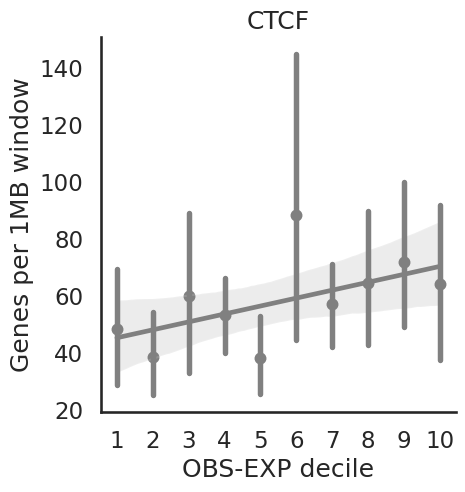

In [217]:
#more divergent than expected
annotation, regions = QuantAnnotate(mod_vars, annot_data = ctcf, annot_type = 'ctcf', quant_bins=10, metric = 'percent_of_max_observed')
g = sns.lmplot(x='divergence_percentile_group', y='annot_count', data=annotation, x_estimator=np.mean, line_kws={'color': 'grey'}, scatter_kws={'color': 'grey'}, height=5)
g.set(xticks=[1,2,3,4,5,6,7,8,9,10],xlabel="OBS-EXP decile", ylabel="Genes per 1MB window", title='CTCF')
slope, intercept, r_value, p_value, std_err = stats.linregress(annotation['divergence_percentile_group'],annotation['annot_count'])
print("r2 = ", str(r_value*r_value) + " p = " + str(p_value))
plt.show()

/scratch/egilbertson/ipykernel_17434/1919460459.py:31: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  annotation = region_list.merge(annotation, on=['chr','start','stop', 'divergence_percentile_group', metric], how='outer')
/scratch/egilbertson/ipykernel_17434/1919460459.py:31: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  annotation = region_list.merge(annotation, on=['chr','start','stop', 'divergence_percentile_group', metric], how='outer')


r2 =  0.00788264881348578 p = 0.2968773757456605


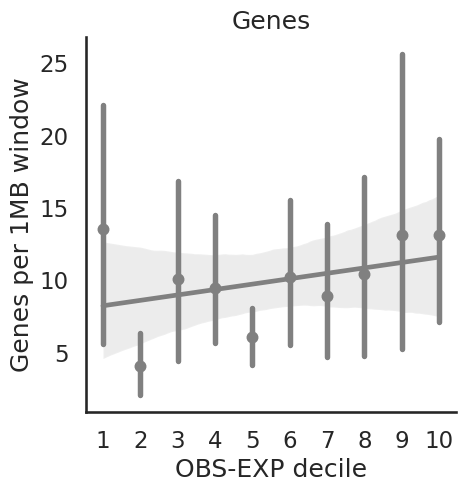

In [218]:
#more divergent than expected
annotation, regions = QuantAnnotate(mod_vars, annot_data = genes, annot_type = 'genes', quant_bins=10, metric = 'percent_of_max_observed')
g = sns.lmplot(x='divergence_percentile_group', y='annot_count', data=annotation, x_estimator=np.mean, line_kws={'color': 'grey'}, scatter_kws={'color': 'grey'}, height=5)
g.set(xticks=[1,2,3,4,5,6,7,8,9,10],xlabel="OBS-EXP decile", ylabel="Genes per 1MB window", title='Genes')
slope, intercept, r_value, p_value, std_err = stats.linregress(annotation['divergence_percentile_group'],annotation['annot_count'])
print("r2 = ", str(r_value*r_value) + " p = " + str(p_value))
plt.show()

# IDWs

## choose variants for IDW mutagenesis

In [236]:
comp_list = pd.read_csv('%s/comp_tables/pairwise_subsample_genomewide_averages.csv' % RESULTS_PATH,
                       index_col=0)
all_indivs = sorted(list(set(comp_list.ind1.unique()) | set(comp_list.ind2.unique())))

In [237]:
comp_list

,ind1,ind2,super1,sub1,sex1,ind1.1,super2,sub2,sex2,ind2.1,...,avg_spearman,avg_divergence,super1.1,sub1.1,sex1.1,ind1.2,super2.1,sub2.1,sex2.1,ind2.2
0,AFR_ASW_female_NA19917,AFR_ASW_female_NA19901,AFR,ASW,female,NA19917,AFR,ASW,female,NA19901,...,0.996195,0.003805,AFR,ASW,female,NA19917,AFR,ASW,female,NA19901
1,AFR_ASW_female_NA19917,AFR_ASW_female_NA20314,AFR,ASW,female,NA19917,AFR,ASW,female,NA20314,...,0.996164,0.003836,AFR,ASW,female,NA19917,AFR,ASW,female,NA20314
2,AFR_ASW_female_NA19917,AFR_ASW_female_NA20317,AFR,ASW,female,NA19917,AFR,ASW,female,NA20317,...,0.995868,0.004132,AFR,ASW,female,NA19917,AFR,ASW,female,NA20317
3,AFR_ASW_female_NA19917,AFR_ASW_female_NA19625,AFR,ASW,female,NA19917,AFR,ASW,female,NA19625,...,0.995808,0.004192,AFR,ASW,female,NA19917,AFR,ASW,female,NA19625
4,AFR_ASW_female_NA19917,AFR_ACB_female_HG02337,AFR,ASW,female,NA19917,AFR,ACB,female,HG02337,...,0.995922,0.004078,AFR,ASW,female,NA19917,AFR,ACB,female,HG02337
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8380,EUR_CEU_female_NA12044,EUR_CEU_female_NA06985,EUR,CEU,female,NA12044,EUR,CEU,female,NA06985,...,0.997105,0.002895,EUR,CEU,female,NA12044,EUR,CEU,female,NA06985
8381,EUR_CEU_female_NA12044,EUR_CEU_female_NA12046,EUR,CEU,female,NA12044,EUR,CEU,female,NA12046,...,0.997350,0.002650,EUR,CEU,female,NA12044,EUR,CEU,female,NA12046
8382,EUR_CEU_female_NA07000,EUR_CEU_female_NA06985,EUR,CEU,female,NA07000,EUR,CEU,female,NA06985,...,0.997287,0.002713,EUR,CEU,female,NA07000,EUR,CEU,female,NA06985
8383,EUR_CEU_female_NA07000,EUR_CEU_female_NA12046,EUR,CEU,female,NA07000,EUR,CEU,female,NA12046,...,0.997193,0.002807,EUR,CEU,female,NA07000,EUR,CEU,female,NA12046


In [238]:
indivs = comp_list[['ind1','super1','sub1','sex1','ind1.1']]
indivs = indivs.drop_duplicates()
extra_ind = comp_list[comp_list.ind2 == 'EUR_CEU_female_NA12046'][['ind2','super2','sub2','sex2','ind2.2']].drop_duplicates()
extra_ind.columns = indivs.columns
indivs = pd.concat([indivs, extra_ind], axis=0, ignore_index=True)

In [239]:
indivs = pd.DataFrame(columns = ['name','super','sub','sex','id'])
for i in all_indivs:
    if i in list(comp_list['ind1']):
        new = comp_list[comp_list.ind1 == i][['ind1','super1','sub1','sex1','ind1.1']].drop_duplicates()
    elif i in list(comp_list['ind2']):
        new = comp_list[comp_list.ind2 == i][['ind2','super2','sub2','sex2','ind2.2']].drop_duplicates()
    new.columns = indivs.columns
    indivs = pd.concat([indivs, new], axis=0, ignore_index=True)


In [240]:
indivs


,name,super,sub,sex,id
0,AFR_ACB_female_HG01896,AFR,ACB,female,HG01896
1,AFR_ACB_female_HG02095,AFR,ACB,female,HG02095
2,AFR_ACB_female_HG02337,AFR,ACB,female,HG02337
3,AFR_ACB_female_HG02505,AFR,ACB,female,HG02505
4,AFR_ACB_female_HG02555,AFR,ACB,female,HG02555
...,...,...,...,...,...
125,SAS_STU_female_HG03673,SAS,STU,female,HG03673
126,SAS_STU_female_HG03836,SAS,STU,female,HG03836
127,SAS_STU_female_HG03886,SAS,STU,female,HG03886
128,SAS_STU_female_HG03944,SAS,STU,female,HG03944


In [342]:
vcf_header = pd.read_table('%s/vcfs/vcf_header.txt' % DATA_PATH, header=None, usecols=[i for i in range(9,2557)])
vcf_header = vcf_header.T.reset_index()

In [346]:
vcf_header['index'] = vcf_header['index']-5

In [347]:
vcf_header[vcf_header[0] =='HG04183']

,index,0
1658,1662,HG04183


In [348]:
indivs

,name,super,sub,sex,id
0,AFR_ACB_female_HG01896,AFR,ACB,female,HG01896
1,AFR_ACB_female_HG02095,AFR,ACB,female,HG02095
2,AFR_ACB_female_HG02337,AFR,ACB,female,HG02337
3,AFR_ACB_female_HG02505,AFR,ACB,female,HG02505
4,AFR_ACB_female_HG02555,AFR,ACB,female,HG02555
...,...,...,...,...,...
125,SAS_STU_female_HG03673,SAS,STU,female,HG03673
126,SAS_STU_female_HG03836,SAS,STU,female,HG03836
127,SAS_STU_female_HG03886,SAS,STU,female,HG03886
128,SAS_STU_female_HG03944,SAS,STU,female,HG03944


In [349]:
vcf_header

,index,0
0,4,HG00096
1,5,HG00097
2,6,HG00099
3,7,HG00100
4,8,HG00101
...,...,...
2543,2547,NA21137
2544,2548,NA21141
2545,2549,NA21142
2546,2550,NA21143


In [350]:
indivs = indivs.merge(vcf_header, left_on='id', right_on=0).sort_values(by='index')

In [351]:
indivs

,name,super,sub,sex,id,index,0
90,EUR_GBR_female_HG00130,EUR,GBR,female,HG00130,36,HG00130
91,EUR_GBR_female_HG00237,EUR,GBR,female,HG00237,87,HG00237
92,EUR_GBR_female_HG00238,EUR,GBR,female,HG00238,88,HG00238
93,EUR_GBR_female_HG00239,EUR,GBR,female,HG00239,89,HG00239
94,EUR_GBR_female_HG00255,EUR,GBR,female,HG00255,102,HG00255
...,...,...,...,...,...,...,...
110,SAS_GIH_female_NA20849,SAS,GIH,female,NA20849,2449,NA20849
111,SAS_GIH_female_NA20869,SAS,GIH,female,NA20869,2465,NA20869
112,SAS_GIH_female_NA20882,SAS,GIH,female,NA20882,2475,NA20882
113,SAS_GIH_female_NA20894,SAS,GIH,female,NA20894,2486,NA20894


In [352]:
indivs.to_csv('%s/vcfs/vcf_indexing.txt' % DATA_PATH)

In [353]:
a = list(indivs['index']+1)

In [354]:
a.sort()

In [355]:
a

[37,
 88,
 89,
 90,
 103,
 152,
 156,
 157,
 159,
 191,
 237,
 252,
 256,
 262,
 266,
 283,
 327,
 385,
 403,
 413,
 415,
 448,
 466,
 474,
 504,
 518,
 534,
 595,
 604,
 609,
 610,
 640,
 642,
 647,
 684,
 689,
 702,
 729,
 789,
 793,
 806,
 817,
 833,
 858,
 875,
 889,
 898,
 916,
 992,
 1006,
 1042,
 1048,
 1052,
 1062,
 1083,
 1086,
 1121,
 1138,
 1144,
 1155,
 1163,
 1211,
 1223,
 1243,
 1307,
 1335,
 1353,
 1374,
 1377,
 1379,
 1382,
 1388,
 1391,
 1412,
 1471,
 1479,
 1481,
 1509,
 1539,
 1572,
 1575,
 1657,
 1663,
 1672,
 1674,
 1692,
 1696,
 1730,
 1732,
 1773,
 1813,
 1822,
 1855,
 1859,
 1889,
 1955,
 1984,
 1994,
 2000,
 2018,
 2027,
 2059,
 2078,
 2083,
 2086,
 2099,
 2110,
 2132,
 2191,
 2199,
 2211,
 2221,
 2241,
 2259,
 2262,
 2273,
 2289,
 2296,
 2317,
 2318,
 2339,
 2361,
 2365,
 2401,
 2407,
 2450,
 2466,
 2476,
 2487,
 2489]

In [40]:
indivs

,name,super,sub,sex,id,index,0
90,EUR_GBR_female_HG00130,EUR,GBR,female,HG00130,41,HG00130
91,EUR_GBR_female_HG00237,EUR,GBR,female,HG00237,92,HG00237
92,EUR_GBR_female_HG00238,EUR,GBR,female,HG00238,93,HG00238
93,EUR_GBR_female_HG00239,EUR,GBR,female,HG00239,94,HG00239
94,EUR_GBR_female_HG00255,EUR,GBR,female,HG00255,107,HG00255
...,...,...,...,...,...,...,...
110,SAS_GIH_female_NA20849,SAS,GIH,female,NA20849,2454,NA20849
111,SAS_GIH_female_NA20869,SAS,GIH,female,NA20869,2470,NA20869
112,SAS_GIH_female_NA20882,SAS,GIH,female,NA20882,2480,NA20882
113,SAS_GIH_female_NA20894,SAS,GIH,female,NA20894,2491,NA20894


In [15]:
idw_vars_non_ref = pd.read_table("%s/IDWs/IDW_variants_non-ref.txt" % DATA_PATH, header=None, names = ['chr', 'pos', 'ref', 'alt', 'window_start'])
idw_vars_non_ref['window_start'] = idw_vars_non_ref['window_start'] + 1
idw_vars_ref = pd.read_table("%s/IDWs/IDW_variants_ref.txt" % DATA_PATH, header=None, names = ['chr', 'pos', 'ref', 'alt', 'window_start'])
idw_vars_ref['window_start'] = idw_vars_ref['window_start'] + 1

In [16]:
idw_vars_non_ref['chr'] = 'chr' + idw_vars_non_ref['chr'].astype(str)

In [17]:
idw_vars_ref['chr'] = 'chr' + idw_vars_ref['chr'].astype(str)

In [18]:
idw_vars_non_ref[idw_vars_non_ref.chr=='chr1'].sort_values(by='pos')

,chr,pos,ref,alt,window_start
3068,chr1,23663528,C,T,23592960
3069,chr1,23760986,T,C,23592960
3070,chr1,23904944,G,A,23592960
3071,chr1,23905564,C,T,23592960
3072,chr1,23923378,A,G,23592960
...,...,...,...,...,...
93067,chr1,160822048,G,A,159907840
93068,chr1,160872709,G,C,159907840
93069,chr1,160908490,A,G,159907840
93070,chr1,160935878,G,A,159907840


In [19]:
idw_vars_non_ref.to_csv('%s/in_silico_mutagenesis/variants_in_divergent_windows_idw_non_ref.txt' % DATA_PATH, sep='\t', header=False, index=False)

In [20]:
idw_vars_ref.to_csv('%s/in_silico_mutagenesis/variants_in_divergent_windows_idw_ref.txt' % DATA_PATH, sep='\t', header=False, index=False)

In [38]:
idw_vars_non_ref.chr.unique()


array(['chr6', 'chr7', 'chr10', 'chr4', 'chr9', 'chr3', 'chr1', 'chr2',
       'chr5', 'chr8', 'chr11', 'chr15', 'chr12', 'chr19', 'chr13',
       'chr22'], dtype=object)

## few windows, all variants

In [315]:
chr3_HG04183 = pd.read_table('%s/in_silico_mutagenesis/all_variants_few_windows/chr3_one_zero_genotypes.txt' % DATA_PATH, names =['chr','pos','ref','alt','status'])
chr3_HG04183['window'] = 174587904
chr3_HG04183['chr'] = 'chr' + chr3_HG04183['chr'].apply(str)
chr3_HG04183 = chr3_HG04183[chr3_HG04183.status>0].loc[chr3_HG04183['ref'].str.len() == 1].loc[chr3_HG04183['alt'].str.len() == 1][['chr','pos','ref','alt','window']]
chr3_HG04183.to_csv('%s/IDWs/chr3_HG04183_variants.txt' % DATA_PATH, sep='\t', header=None, index=False)


In [335]:
chr3_HG04183 = chr3_HG04183.reset_index(drop=True)
chr3_HG04183[chr3_HG04183.pos==175288067]

,chr,pos,ref,alt,window
1203,chr3,175288067,C,T,174587904


In [318]:
chr4_HG00864 = pd.read_table('%s/in_silico_mutagenesis/all_variants_few_windows/chr4_one_zero_genotypes.txt' % DATA_PATH, names =['chr','pos','ref','alt','status'])
chr4_HG00864['window'] = 27262976
chr4_HG00864['chr'] = 'chr' + chr4_HG00864['chr'].apply(str)
chr4_HG00864 = chr4_HG00864[chr4_HG00864.status>0].loc[chr4_HG00864['ref'].str.len() == 1].loc[chr4_HG00864['alt'].str.len() == 1][['chr','pos','ref','alt','window']]
chr4_HG00864.to_csv('%s/IDWs/chr4_HG00864_variants.txt' % DATA_PATH, sep='\t', header=None, index=False)


In [338]:
chr4_HG00864 = chr4_HG00864.reset_index(drop=True)
chr4_HG00864[chr4_HG00864.pos==28251340]


,chr,pos,ref,alt,window
1680,chr4,28251340,A,G,27262976


In [329]:
chr4_HG00864

,chr,pos,ref,alt,window
0,chr4,27264352,C,A,27262976
1,chr4,27266720,T,C,27262976
2,chr4,27266801,T,C,27262976
3,chr4,27267786,G,A,27262976
4,chr4,27268305,T,C,27262976
...,...,...,...,...,...
1835,chr4,28308603,G,A,27262976
1836,chr4,28308809,C,T,27262976
1837,chr4,28308927,A,T,27262976
1838,chr4,28310981,G,A,27262976


In [319]:
chr14_HG02946 = pd.read_table('%s/in_silico_mutagenesis/all_variants_few_windows/chr14_one_zero_genotypes.txt' % DATA_PATH, names =['chr','pos','ref','alt','status'])
chr14_HG02946['window'] = 46137344
chr14_HG02946['chr'] = 'chr' + chr14_HG02946['chr'].apply(str)
chr14_HG02946 = chr14_HG02946[chr14_HG02946.status>0].loc[chr14_HG02946['ref'].str.len() == 1].loc[chr14_HG02946['alt'].str.len() == 1][['chr','pos','ref','alt','window']]
chr14_HG02946.to_csv('%s/IDWs/chr14_HG02946_variants.txt' % DATA_PATH, sep='\t', header=None, index=False)


In [339]:
chr14_HG02946 = chr14_HG02946.reset_index(drop=True)
chr14_HG02946[chr14_HG02946.pos==46707124]

,chr,pos,ref,alt,window
1099,chr14,46707124,A,G,46137344


In [337]:
chr14_HG02946

,chr,pos,ref,alt,window
0,chr14,46137491,T,A,46137344
1,chr14,46138599,T,C,46137344
2,chr14,46138871,T,C,46137344
3,chr14,46138932,G,T,46137344
4,chr14,46141118,C,A,46137344
...,...,...,...,...,...
1839,chr14,47180712,A,G,46137344
1840,chr14,47181718,A,G,46137344
1841,chr14,47183122,G,A,46137344
1842,chr14,47184018,C,T,46137344




## load in mutagenesis files and set up dictionary data structure

run in command line for bash script
```
head -n 1 ism_scores_idw_rare_alternate_1.txt > ism_scores_idw_rare_alternate.txt
for i in {1..30}; do tail -n +2 ism_scores_idw_rare_alternate_$i.txt >> div.tmp; done
sort -k1,1 -k2n,2 div.tmp >> ism_scores_idw_rare_alternate.txt
rm div.tmp
```

## Rare alternate allele

In [162]:
ism = pd.read_table('%s/in_silico_mutagenesis/IDW/ism_scores_idw_rare_alternate.txt' % DATA_PATH)
# ancestral 3D dataframes
anc_spear = pd.read_table('%s/comp_tables/anc_window_spearman.csv' % RESULTS_PATH
                    , sep=',', header=[0,1,2,3], index_col=[0,1])
anc_div = 1-anc_spear

ref_spear = pd.read_table('%s/comp_tables/ref_window_spearman.csv' % RESULTS_PATH
                    , sep=',', header=[0,1,2,3], index_col=[0,1])
ref_div = 1-ref_spear


In [188]:
ism[ism.chr=='chr3'][ism.window ==174587904]

/scratch/egilbertson/ipykernel_13288/4073497989.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ism[ism.chr=='chr3'][ism.window ==174587904]


,chr,pos,window,ref,alt,mse,1-pearson,1-spearman
36432,chr3,174589271,174587904,C,A,9.574029e-10,8.545566e-08,8.352505e-08
36433,chr3,174682407,174587904,A,G,8.018209e-10,6.510608e-08,6.745300e-08
36434,chr3,174689001,174587904,G,T,8.215969e-09,5.604102e-07,5.397059e-07
36435,chr3,174689087,174587904,A,G,8.865020e-08,5.820467e-06,6.483449e-06
36436,chr3,174691023,174587904,C,T,7.027962e-09,5.784595e-07,5.747558e-07
36437,chr3,174691502,174587904,T,C,1.449487e-08,1.027783e-06,1.159931e-06
36438,chr3,174691778,174587904,C,T,2.470425e-08,1.749603e-06,1.990924e-06
36439,chr3,174697827,174587904,C,T,4.429887e-09,3.228801e-07,2.710779e-07
36440,chr3,174700115,174587904,A,C,1.595842e-09,1.138997e-07,9.102937e-08
36441,chr3,174747332,174587904,C,T,4.449480e-09,3.648701e-07,3.896950e-07


In [164]:
ism.sort_values(by=['1-spearman'], ascending=False)[ism['1-spearman']>0.01]

/scratch/egilbertson/ipykernel_13288/1446350733.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ism.sort_values(by=['1-spearman'], ascending=False)[ism['1-spearman']>0.01]


,chr,pos,window,ref,alt,mse,1-pearson,1-spearman
36453,chr3,175318568,174587904,C,G,0.016305,0.688301,0.557366
47298,chr6,60572812,60293120,G,C,0.011404,0.314761,0.391712
14422,chr14,46581275,46137344,G,A,0.006225,0.310098,0.365355
57020,chr8,115076908,114294784,T,G,0.010220,0.321467,0.342894
32073,chr3,7418768,6815744,G,T,0.005399,0.328745,0.339053
...,...,...,...,...,...,...,...,...
53769,chr8,6919478,6291456,C,T,0.006894,0.009715,0.010263
22469,chr19,34501744,33554432,G,T,0.003439,0.009209,0.010205
50019,chr7,14458016,14155776,G,C,0.002531,0.008630,0.010143
50951,chr7,51067856,50855936,C,T,0.001420,0.006273,0.010114


In [165]:
ism[ism['1-spearman']>0.01]

,chr,pos,window,ref,alt,mse,1-pearson,1-spearman
180,chr1,11337694,10485760,C,A,0.005162,0.009666,0.013013
181,chr1,11337694,11010048,C,A,0.013379,0.024743,0.034327
604,chr1,40669065,39845888,C,G,0.007868,0.011231,0.014895
605,chr1,40669065,40370176,C,G,0.009211,0.023105,0.024510
678,chr1,43529306,42991616,C,T,0.004743,0.012921,0.015124
...,...,...,...,...,...,...,...,...
59602,chr9,119992033,119537664,C,G,0.000694,0.016668,0.015273
59637,chr9,125558633,124780544,G,A,0.003767,0.008478,0.013169
59638,chr9,125558633,125304832,G,A,0.004802,0.042204,0.047838
59738,chr9,132436669,132120576,T,C,0.006279,0.011772,0.012151


In [166]:
ref_div

AFR                                          \
                           ACB                                           
                        female                                           
                       HG01880   HG01883   HG01886   HG01889   HG01894   
chr   windowStartPos                                                     
chr1  1048576         0.001887  0.002376  0.002090  0.002764  0.005446   
      1572864         0.001455  0.002149  0.002353  0.002451  0.006055   
      3145728         0.005796  0.005204  0.005573  0.008185  0.004474   
      3670016         0.002717  0.002889  0.008788  0.005876  0.003651   
      4194304         0.001733  0.003498  0.007328  0.007026  0.004076   
...                        ...       ...       ...       ...       ...   
chr22 46661632        0.009996  0.002464  0.008487  0.015501  0.003501   
      47185920        0.031880  0.004652  0.002002  0.042038  0.004407   
      47710208        0.031723  0.038461  0.058351  0.115267  0.022607   
      48234496        0.190171  0.201378  0.247603  0.335508  0.209896   
      48758784        0.011144  0.019188  0.009220  0.022198  0.020404   

                                                                        ...  \
                                                                        ...   
                                                                        ...   
                       HG01896   HG01915   HG01956   HG01958   HG01985  ...   
chr   windowStartPos                                                    ...   
chr1  1048576         0.002805  0.002136  0.001302  0.003039  0.003233  ...   
      1572864         0.003397  0.002525  0.002937  0.007916  0.004073  ...   
      3145728         0.004200  0.005482  0.005160  0.005465  0.003913  ...   
      3670016         0.005854  0.002427  0.002797  0.001939  0.004082  ...   
      4194304         0.007798  0.001625  0.002338  0.001345  0.005976  ...   
...                        ...       ...       ...       ...       ...  ...   
chr22 46661632        0.006056  0.006623  0.013751  0.003791  0.018544  ...   
      47185920        0.012663  0.001999  0.011571  0.005230  0.003504  ...   
      47710208        0.037339  0.038931  0.024375  0.032503  0.028956  ...   
      48234496        0.183877  0.191428  0.208325  0.176306  0.172264  ...   
      48758784        0.008924  0.014129  0.019617  0.009365  0.018164  ...   

                           SAS                                          \
                           STU                                           
                          male                                           
                       HG03998   HG03999   HG04003   HG04006   HG04033   
chr   windowStartPos                                                     
chr1  1048576         0.000480  0.001085  0.001656  0.001277  0.001722   
      1572864         0.000603  0.000892  0.001194  0.000780  0.001999   
      3145728         0.000978  0.000527  0.005660  0.004791  0.005334   
      3670016         0.001717  0.002433  0.003300  0.007131  0.003658   
      4194304         0.003887  0.004071  0.004998  0.009375  0.002547   
...                        ...       ...       ...       ...       ...   
chr22 46661632        0.002449  0.006114  0.002542  0.007057  0.004045   
      47185920        0.007317  0.002561  0.002313  0.003355  0.000844   
      47710208        0.031409  0.040545  0.029263  0.028312  0.039730   
      48234496        0.175491  0.194221  0.165757  0.167578  0.200535   
      48758784        0.010696  0.013681  0.010503  0.009266  0.012941   

                                                                        
                                                                        
                                                                        
                       HG04039   HG04100   HG04107   HG04210   HG04229  
chr   windowStartPos                                                    
chr1  1048576         0.001

In [167]:
idw_list = pd.read_table("%s/IDWs/idw_mut_params.txt" % DATA_PATH, names = ['vcf_col_id','chr','window_start','window_end','individual', 'depth'])
idw_list.index = list(zip(idw_list.chr, idw_list.window_start))


In [168]:
idw_list[idw_list.chr=='chr3'][idw_list.window_start == 174587904]

/scratch/egilbertson/ipykernel_13288/3214724591.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  idw_list[idw_list.chr=='chr3'][idw_list.window_start == 174587904]


,vcf_col_id,chr,window_start,window_end,individual,depth
"(chr3, 174587904)",87,chr3,174587904,175636480,SAS_BEB_female_HG04183,0.632987


### comparing to reference

In [169]:
ind = idw_list.loc[[idw_list.index[0]]].individual[0]

In [170]:
i = idw_list.index[0]

In [171]:
i[0]

'chr1'

In [172]:
ism[ism.chr==i[0]][ism.window==i[1]]

/scratch/egilbertson/ipykernel_13288/4274786638.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ism[ism.chr==i[0]][ism.window==i[1]]


,chr,pos,window,ref,alt,mse,1-pearson,1-spearman
0,chr1,3732688,3670016,A,AC,NaN,NaN,NaN
1,chr1,3760758,3670016,T,G,9.714308e-08,1.496074e-07,2.177228e-07
2,chr1,3880554,3670016,C,T,3.777337e-07,7.379900e-07,1.525400e-06
3,chr1,3959104,3670016,C,T,3.469086e-08,6.555761e-08,1.744102e-07
4,chr1,3965875,3670016,C,T,7.504695e-07,7.966452e-07,2.335052e-06
5,chr1,3967782,3670016,T,C,2.690805e-08,1.820807e-08,5.624173e-08
6,chr1,3970139,3670016,A,G,1.744247e-07,3.056634e-07,1.240914e-06
7,chr1,4027982,3670016,G,C,1.036009e-07,1.819347e-07,7.648667e-07
8,chr1,4178811,3670016,C,T,3.247639e-04,6.548693e-04,5.059178e-03
9,chr1,4320091,3670016,C,T,4.669197e-09,9.540262e-09,1.002747e-07


In [173]:
idw_list.loc[[i]]

,vcf_col_id,chr,window_start,window_end,individual,depth
"(chr1, 3670016)",121,chr1,3670016,4718592,AFR_ASW_female_NA19901,0.016704


In [174]:
max_divs = []
all_percs = []
ism_dict = {}
max_os = {}
for i in idw_list.index:
    r = ref_div.loc[i]
    ind = idw_list.loc[[i]].individual[0]
    if ind.split("_")[3] == 'HG02069':
        continue
    max_o = r[ind.split("_")[0]][ind.split("_")[1]][ind.split("_")[2]][ind.split("_")[3]]
    chr = i[0]
    window = i[1]
    arry = ism[ism.chr==chr][ism.window==window]
    if arry.shape[0]>0:
        max_os[i] = max_o
        arry['percent_of_max_observed'] = arry['1-spearman']/max_o
        max_divs.append(arry['1-spearman'].max())
        ism_dict[i] = arry
        all_percs = all_percs + list(arry['percent_of_max_observed'])

/scratch/egilbertson/ipykernel_13288/834577551.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  arry = ism[ism.chr==chr][ism.window==window]
/scratch/egilbertson/ipykernel_13288/834577551.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  arry = ism[ism.chr==chr][ism.window==window]
/scratch/egilbertson/ipykernel_13288/834577551.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  arry = ism[ism.chr==chr][ism.window==window]
/scratch/egilbertson/ipykernel_13288/834577551.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  arry = ism[ism.chr==chr][ism.window==window]
/scratch/egilbertson/ipykernel_13288/834577551.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  arry = ism[ism.chr==chr][ism.window==window]
/scratch/egilbertson/ipykernel_13288/834577551.py:13: UserWarning: Boolean Series key will be reindexed to match Da

Text(0, 0.5, 'Number of SNPs')

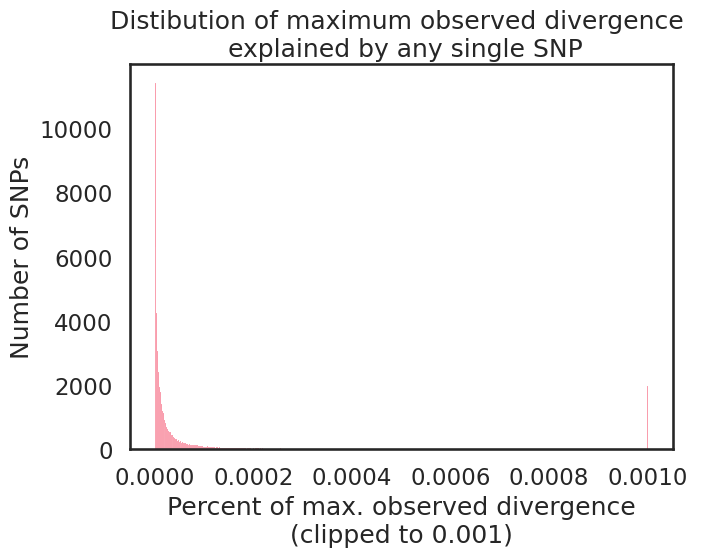

In [177]:
all_percs_clip = np.array(all_percs).clip(0,.0010)

plt.figure(figsize=(7,5))
sns.histplot(all_percs_clip)
plt.title('Distibution of maximum observed divergence \n explained by any single SNP')
plt.xlabel('Percent of max. observed divergence\n(clipped to 0.001)')
plt.ylabel('Number of SNPs')

Text(0, 0.5, 'Number of windows')

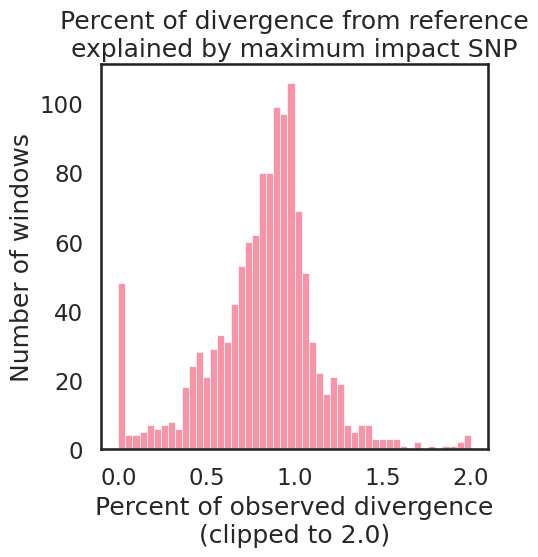

In [183]:
max_snp = []
for w in ism_dict.keys():
    max_snp.append(ism_dict[w]['percent_of_max_observed'].max())
    
max_snp = np.array(max_snp).clip(0,2)

plt.figure(figsize=(5,5))
sns.histplot(max_snp, bins=50)
plt.title('Percent of divergence from reference\nexplained by maximum impact SNP')
plt.xlabel('Percent of observed divergence\n(clipped to 2.0)')
plt.ylabel('Number of windows')

Text(0, 0.5, 'Number of windows')

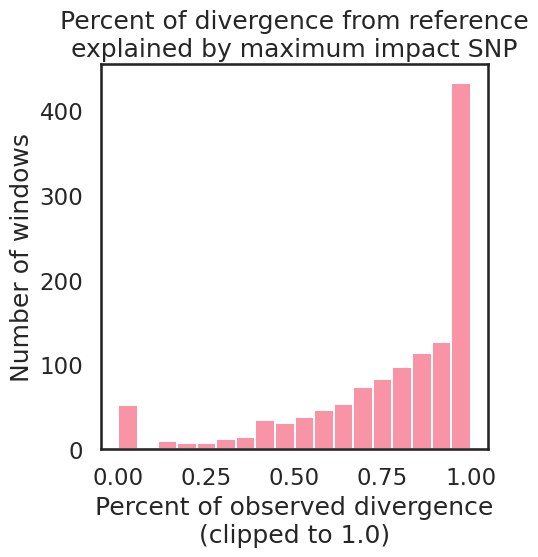

In [185]:
max_snp = []
for w in ism_dict.keys():
    max_snp.append(ism_dict[w]['percent_of_max_observed'].max())
    
max_snp = np.array(max_snp).clip(0,1)

plt.figure(figsize=(5,5))
sns.histplot(max_snp)
plt.title('Percent of divergence from reference\nexplained by maximum impact SNP')
plt.xlabel('Percent of observed divergence\n(clipped to 1.0)')
plt.ylabel('Number of windows')

Text(0, 0.5, 'Number of windows')

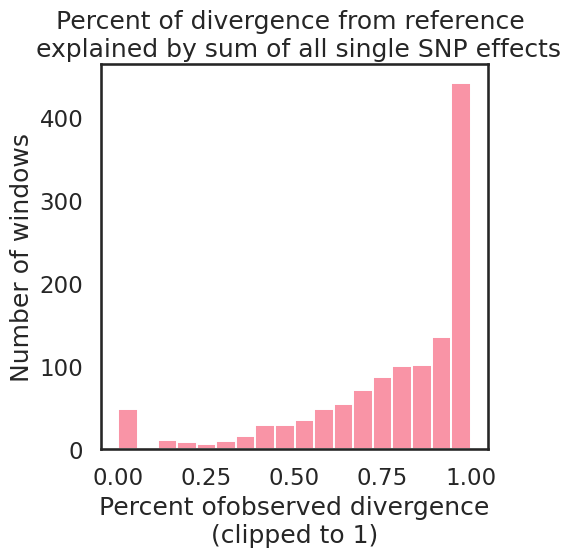

In [186]:
additive = []
for w in ism_dict.keys():
    additive.append(ism_dict[w]['percent_of_max_observed'].sum())
    
additive = np.array(additive).clip(0,1)

plt.figure(figsize=(5,5))
sns.histplot(additive)
plt.title('Percent of divergence from reference \n explained by sum of all single SNP effects')
plt.xlabel('Percent ofobserved divergence\n(clipped to 1)')
plt.ylabel('Number of windows')

Text(0, 0.5, 'Number of windows')

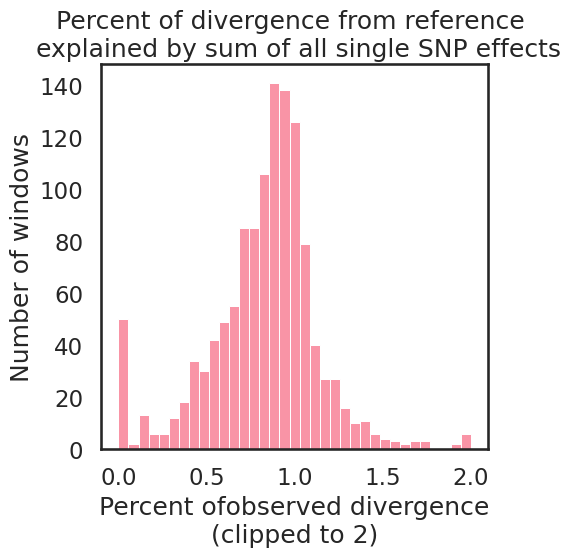

In [187]:
additive = []
for w in ism_dict.keys():
    additive.append(ism_dict[w]['percent_of_max_observed'].sum())
    
additive = np.array(additive).clip(0,2)

plt.figure(figsize=(5,5))
sns.histplot(additive)
plt.title('Percent of divergence from reference \n explained by sum of all single SNP effects')
plt.xlabel('Percent ofobserved divergence\n(clipped to 2)')
plt.ylabel('Number of windows')

## Annotate 3D disrupting variants

### ID disrupting variants

In [193]:
ism_dict.keys()

dict_keys([('chr1', 3670016), ('chr1', 6291456), ('chr1', 7340032), ('chr1', 10485760), ('chr1', 11010048), ('chr1', 22020096), ('chr1', 23592960), ('chr1', 25690112), ('chr1', 26214400), ('chr1', 38797312), ('chr1', 39845888), ('chr1', 40370176), ('chr1', 42991616), ('chr1', 44040192), ('chr1', 44564480), ('chr1', 45088768), ('chr1', 48758784), ('chr1', 49807360), ('chr1', 54525952), ('chr1', 56098816), ('chr1', 58720256), ('chr1', 59244544), ('chr1', 59768832), ('chr1', 61865984), ('chr1', 62914560), ('chr1', 66584576), ('chr1', 70254592), ('chr1', 71827456), ('chr1', 72351744), ('chr1', 73400320), ('chr1', 76021760), ('chr1', 76546048), ('chr1', 77594624), ('chr1', 78643200), ('chr1', 79167488), ('chr1', 83361792), ('chr1', 93323264), ('chr1', 93847552), ('chr1', 94896128), ('chr1', 100663296), ('chr1', 101187584), ('chr1', 103809024), ('chr1', 104333312), ('chr1', 105906176), ('chr1', 108527616), ('chr1', 109051904), ('chr1', 115867648), ('chr1', 116391936), ('chr1', 116916224), ('

In [194]:
mod_vars = pd.DataFrame(columns = ism.columns)
for w in ism_dict.keys():
    df = ism_dict[w]
    df = df[df['percent_of_max_observed'] > .5]
    if df.shape[0] != 0:
        mod_vars = pd.concat([mod_vars, df])
mod_vars

,chr,pos,window,ref,alt,mse,1-pearson,1-spearman,percent_of_max_observed
74,chr1,7539912,7340032,C,T,0.000695,0.000907,0.001245,0.940472
180,chr1,11337694,10485760,C,A,0.005162,0.009666,0.013013,0.900147
181,chr1,11337694,11010048,C,A,0.013379,0.024743,0.034327,0.802554
232,chr1,22416772,22020096,G,C,0.001768,0.002983,0.003187,0.918342
299,chr1,23784808,23592960,G,A,0.000775,0.003034,0.003659,0.940832
...,...,...,...,...,...,...,...,...,...
31425,chr22,41517934,40894464,C,G,0.002396,0.005910,0.006624,0.661563
31443,chr22,43885183,43515904,T,G,0.003262,0.006039,0.005117,0.654700
31491,chr22,45082995,44564480,G,A,0.006722,0.019600,0.017392,0.955910
31552,chr22,46122617,45613056,G,T,0.010370,0.022550,0.021260,1.090398


In [195]:
mod_vars = pd.DataFrame(columns = ism.columns)
for w in ism_dict.keys():
    df = ism_dict[w]
    df = df[df['percent_of_max_observed'] > .2]
    if df.shape[0] != 0:
        mod_vars = pd.concat([mod_vars, df])
mod_vars

,chr,pos,window,ref,alt,mse,1-pearson,1-spearman,percent_of_max_observed
8,chr1,4178811,3670016,C,T,0.000325,0.000655,0.005059,0.397345
40,chr1,6662581,6291456,A,G,0.000596,0.000966,0.001081,0.268514
74,chr1,7539912,7340032,C,T,0.000695,0.000907,0.001245,0.940472
180,chr1,11337694,10485760,C,A,0.005162,0.009666,0.013013,0.900147
181,chr1,11337694,11010048,C,A,0.013379,0.024743,0.034327,0.802554
...,...,...,...,...,...,...,...,...,...
31425,chr22,41517934,40894464,C,G,0.002396,0.005910,0.006624,0.661563
31443,chr22,43885183,43515904,T,G,0.003262,0.006039,0.005117,0.654700
31491,chr22,45082995,44564480,G,A,0.006722,0.019600,0.017392,0.955910
31552,chr22,46122617,45613056,G,T,0.010370,0.022550,0.021260,1.090398


In [196]:
mod_vars['pos+1'] = mod_vars['pos'] +1
mod_vars = mod_vars[['chr','pos', 'pos+1','window','ref','alt','percent_of_max_observed']]

### genomic annotations

In [197]:
ctcf = pybedtools.BedTool('%s/annotations/ctcf_full_merged.bed' % DATA_PATH).merge()
genes = pybedtools.BedTool('%s/annotations/grch38_gene_annotations.bed' % DATA_PATH)

In [198]:
mod_vars_annot = BedTool.from_dataframe(mod_vars).intersect(ctcf, wao=True).to_dataframe(disable_auto_names=True, header=None)
mod_vars_annot.columns = list(mod_vars.columns) + ['elem_chr','elem_start','elem_stop','ctcf']
mod_vars_annot = mod_vars_annot[list(mod_vars.columns) + ['ctcf']]

mod_vars_annot = BedTool.from_dataframe(mod_vars_annot).intersect(genes, wao=True).to_dataframe(disable_auto_names=True, header=None)
mod_vars_annot.columns = list(mod_vars.columns) + ['ctcf'] + ['elem_chr','elem_start','elem_stop','gene_name','genes']
mod_vars_annot = mod_vars_annot[list(mod_vars.columns) + ['ctcf', 'gene_name','genes']]
mod_vars_annot = mod_vars_annot.drop_duplicates(subset = list(mod_vars.columns), ignore_index=True)

phylop=pd.read_table('phylop.txt')
mod_vars_annot['phylop'] = phylop['Mean']


In [205]:
mod_vars_annot

,chr,pos,pos+1,window,ref,alt,percent_of_max_observed,ctcf,gene_name,genes,phylop
0,chr1,4178811,4178812,3670016,C,T,0.397345,0,.,0,0.387512
1,chr1,6662581,6662582,6291456,A,G,0.268514,1,DNAJC11,1,2.035560
2,chr1,7539912,7539913,7340032,C,T,0.940472,0,CAMTA1,1,0.225583
3,chr1,11337694,11337695,10485760,C,A,0.900147,0,.,0,6.199230
4,chr1,11337694,11337695,11010048,C,A,0.802554,0,.,0,6.199230
...,...,...,...,...,...,...,...,...,...,...,...
1172,chr22,41517934,41517935,40894464,C,G,0.661563,0,ACO2,1,NaN
1173,chr22,43885183,43885184,43515904,T,G,0.654700,0,PNPLA5,1,NaN
1174,chr22,45082995,45082996,44564480,G,A,0.955910,0,.,0,NaN
1175,chr22,46122617,46122618,45613056,G,T,1.090398,0,.,0,NaN


In [206]:
phylop

,Chrom,start,end,num_values,num_bases,Bases_covered,Minimum,Maximum,Range,Mean,Variance,Standard_deviation
0,chr1,41924264,41924264,1,1,1 (100.00%),0.387512,0.387512,0,0.387512,0,0
1,chr1,71588165,71588165,1,1,1 (100.00%),2.035560,2.035560,0,2.035560,0,0
2,chr1,89085986,89085986,1,1,1 (100.00%),0.225583,0.225583,0,0.225583,0,0
3,chr1,97870773,97870773,1,1,1 (100.00%),6.199230,6.199230,0,6.199230,0,0
4,chr1,97870773,97870773,1,1,1 (100.00%),6.199230,6.199230,0,6.199230,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
171,chr20,41572207,41572207,1,1,1 (100.00%),1.619590,1.619590,0,1.619590,0,0
172,chr20,53099036,53099036,1,1,1 (100.00%),-0.038354,-0.038354,0,-0.038354,0,0
173,chr21,19735128,19735128,1,1,1 (100.00%),0.415480,0.415480,0,0.415480,0,0
174,chr21,21751496,21751496,1,1,1 (100.00%),-0.011937,-0.011937,0,-0.011937,0,0


Text(0.5, 1.0, 'PhyloP Score distribution for 3D modifying SNPs')

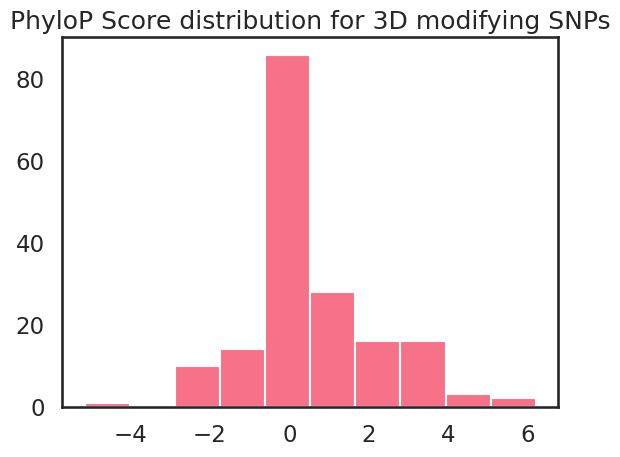

In [199]:
plt.hist(mod_vars_annot['phylop'])
plt.title('PhyloP Score distribution for 3D modifying SNPs')

In [200]:
mod_vars_annot[mod_vars_annot.ctcf==1].shape

(76, 11)

In [201]:
mod_vars_annot[mod_vars_annot.phylop>0]

,chr,pos,pos+1,window,ref,alt,percent_of_max_observed,ctcf,gene_name,genes,phylop
0,chr1,4178811,4178812,3670016,C,T,0.397345,0,.,0,0.387512
1,chr1,6662581,6662582,6291456,A,G,0.268514,1,DNAJC11,1,2.035560
2,chr1,7539912,7539913,7340032,C,T,0.940472,0,CAMTA1,1,0.225583
3,chr1,11337694,11337695,10485760,C,A,0.900147,0,.,0,6.199230
4,chr1,11337694,11337695,11010048,C,A,0.802554,0,.,0,6.199230
...,...,...,...,...,...,...,...,...,...,...,...
168,chr2,194997093,194997094,193986560,C,T,0.647284,0,.,0,0.108244
169,chr2,194997093,194997094,194510848,C,T,0.922476,0,.,0,0.802858
170,chr2,196277211,196277212,195559424,G,T,0.787731,0,HECW2,1,0.944268
171,chr2,197600209,197600210,197132288,C,T,0.538533,0,RFTN2,1,1.619590


In [202]:
mod_vars_annot[mod_vars_annot.phylop<0]

,chr,pos,pos+1,window,ref,alt,percent_of_max_observed,ctcf,gene_name,genes,phylop
10,chr1,40669065,40669066,39845888,C,G,1.068588,0,.,0,-0.635118
11,chr1,40669065,40669066,40370176,C,G,1.054227,0,.,0,-0.635118
12,chr1,43529306,43529307,42991616,C,T,0.749179,0,.,0,-0.109669
16,chr1,48916739,48916740,48758784,C,A,0.895581,1,AGBL4,1,-0.539118
17,chr1,50444039,50444040,49807360,A,G,0.551831,0,FAF1,1,-0.300252
...,...,...,...,...,...,...,...,...,...,...,...
164,chr2,192190639,192190640,191365120,G,C,1.068564,0,TMEFF2,1,-0.401669
165,chr2,192190639,192190640,191889408,G,C,0.923772,0,TMEFF2,1,-0.401669
172,chr2,197743466,197743467,197656576,G,A,0.721730,0,BOLL,1,-0.038354
174,chr2,203097928,203097929,202375168,C,T,0.998965,0,NBEAL1,1,-0.011937


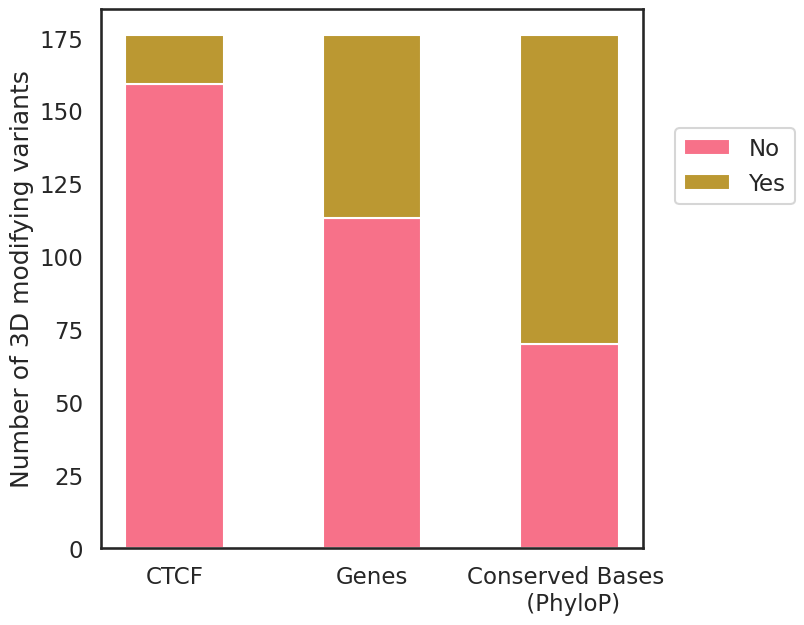

In [203]:
annots = ['CTCF','Genes', 'Conserved Bases \n (PhyloP)']
#1 = conserved phylop> 0 , 0 = fast evolving, phylop<0
annot_counts = {'No':[159, 113,70 ], 'Yes': [17,63, 106]}

width = 0.5

fig, ax = plt.subplots(figsize=(7,7))
bottom = np.zeros(3)

for boolean, annot_counts in annot_counts.items():
    p = ax.bar(annots, annot_counts, width, label=boolean, bottom=bottom)
    bottom += annot_counts

plt.ylabel('Number of 3D modifying variants')
ax.legend(loc="best", bbox_to_anchor=(.8, 0., 0.5, 0.8))

plt.show()

In [ ]:
mod_vars_annot

,chr,pos,pos+1,window,ref,alt,percent_of_max_observed,ctcf,gene_name,genes,phylop
0,chr1,41924264,41924265,41418752,G,A,0.223924,0,.,0,0.387512
1,chr1,71588165,71588166,70778880,G,C,0.293259,0,NEGR1,1,2.035560
2,chr1,89085986,89085987,88604672,G,C,0.416400,0,.,0,0.225583
3,chr1,97870773,97870774,96993280,G,A,0.391997,0,DPYD,1,6.199230
4,chr1,97870773,97870774,97517568,G,A,0.333523,0,DPYD,1,6.199230
...,...,...,...,...,...,...,...,...,...,...,...
171,chr20,41572207,41572208,40894464,G,C,0.684638,0,CHD6,1,1.619590
172,chr20,53099036,53099037,52428800,C,T,0.714326,0,TSHZ2,1,-0.038354
173,chr21,19735128,19735129,19398656,T,A,0.527366,0,.,0,0.415480
174,chr21,21751496,21751497,20971520,A,G,0.253647,0,.,0,-0.011937


<AxesSubplot: xlabel='percent_of_max_observed', ylabel='ctcf'>

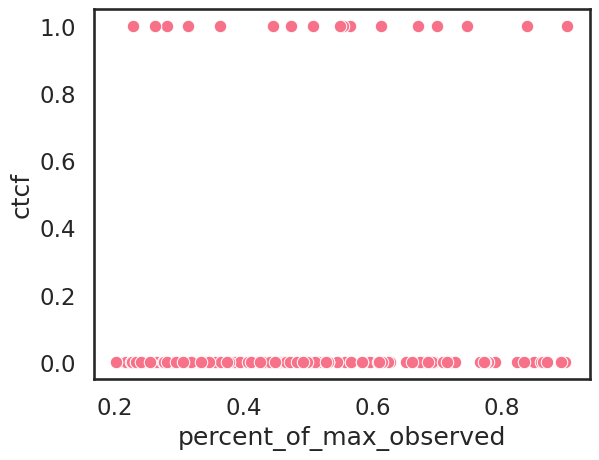

In [ ]:
sns.scatterplot(x='percent_of_max_observed',y = 'ctcf', data = mod_vars_annot)

In [ ]:
def PercentileToQuantile(x, bins):
    numQuants = bins
    quantSize = 1/numQuants
    currentQuant = quantSize
    currentReturn = 1
    numDecs = int(str(quantSize)[::-1].find('.'))
    for i in range(numQuants):
        if x < currentQuant:
            return currentReturn
        elif x == 1:
            return numQuants
        else:
            currentQuant = round((currentQuant + quantSize), numDecs)
            currentReturn += 1


def QuantAnnotate(distStat_df, annot_data, annot_type, quant_bins, metric):
    regions = distStat_df.copy(deep=True)
    regions['divergence_percentile'] = regions[metric].rank(pct=True)
    regions = regions.reset_index()
    regions['divergence_percentile_group'] = regions['divergence_percentile'].apply(PercentileToQuantile, bins=quant_bins)
    regions['stop'] = regions['pos'] + 2**20
    regions = regions[['chr','pos','stop',metric,'divergence_percentile','divergence_percentile_group']]
    regions.columns = ['chr','start','stop'] + list(regions.columns)[3:]
    region_list = regions[['chr','start','stop', 'divergence_percentile_group',metric]]

    if annot_type == 'genes':
        annotation = BedTool.from_dataframe(regions).intersect(annot_data, wo=True).to_dataframe(disable_auto_names=True, header=None)
        annotation.columns = list(regions.columns) + ['elem_chr','elem_start','elem_stop','gene_name','numBases']
        annotation['annot_count'] = 1
        annotation = region_list.merge(annotation, on=['chr','start','stop', 'divergence_percentile_group', metric], how='outer')
        annotation_grouped = annotation.groupby(['chr', 'start','stop']).agg({'numBases': 'sum','annot_count':'sum', 'divergence_percentile_group':'max', metric:'mean'})
        annotation_grouped['propBasesCovered'] = annotation_grouped['numBases']/(2**20)
        annotation_grouped= annotation_grouped.reset_index()

    if annot_type=='ctcf':
        annotation = BedTool.from_dataframe(regions).intersect(annot_data, wo=True).to_dataframe(disable_auto_names=True, header=None)
        annotation.columns = list(regions.columns) + ['elem_chr','elem_start','elem_stop','numBases']
        annotation['annot_count'] = 1
        annotation = region_list.merge(annotation, on=['chr','start','stop', 'divergence_percentile_group', metric], how='outer')
        annotation_grouped = annotation.groupby(['chr', 'start','stop']).agg({'numBases': 'sum','annot_count':'sum', 'divergence_percentile_group':'max', metric:'mean'})
        annotation_grouped['propBasesCovered'] = annotation_grouped['numBases']/(2**20)
        annotation_grouped= annotation_grouped.reset_index()

    return annotation_grouped, regions

/scratch/egilbertson/ipykernel_17434/1919460459.py:40: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  annotation = region_list.merge(annotation, on=['chr','start','stop', 'divergence_percentile_group', metric], how='outer')
/scratch/egilbertson/ipykernel_17434/1919460459.py:40: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  annotation = region_list.merge(annotation, on=['chr','start','stop', 'divergence_percentile_group', metric], how='outer')


r2 =  0.02891983971947727 p = 0.04456109910013466


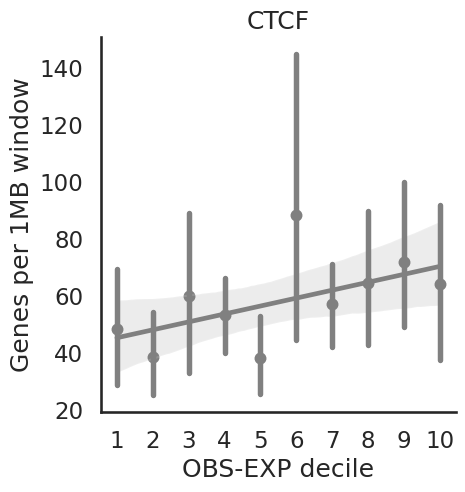

In [ ]:
#more divergent than expected
annotation, regions = QuantAnnotate(mod_vars, annot_data = ctcf, annot_type = 'ctcf', quant_bins=10, metric = 'percent_of_max_observed')
g = sns.lmplot(x='divergence_percentile_group', y='annot_count', data=annotation, x_estimator=np.mean, line_kws={'color': 'grey'}, scatter_kws={'color': 'grey'}, height=5)
g.set(xticks=[1,2,3,4,5,6,7,8,9,10],xlabel="OBS-EXP decile", ylabel="Genes per 1MB window", title='CTCF')
slope, intercept, r_value, p_value, std_err = stats.linregress(annotation['divergence_percentile_group'],annotation['annot_count'])
print("r2 = ", str(r_value*r_value) + " p = " + str(p_value))
plt.show()

/scratch/egilbertson/ipykernel_17434/1919460459.py:31: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  annotation = region_list.merge(annotation, on=['chr','start','stop', 'divergence_percentile_group', metric], how='outer')
/scratch/egilbertson/ipykernel_17434/1919460459.py:31: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  annotation = region_list.merge(annotation, on=['chr','start','stop', 'divergence_percentile_group', metric], how='outer')


r2 =  0.00788264881348578 p = 0.2968773757456605


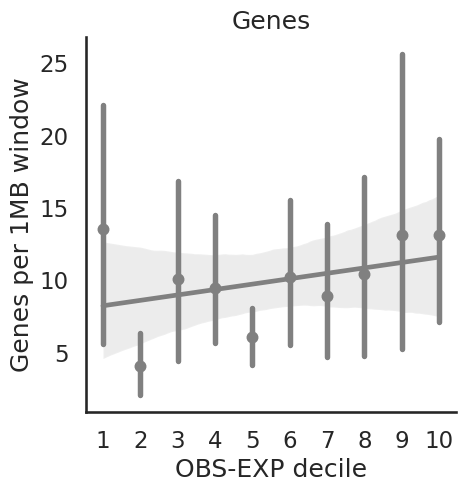

In [ ]:
#more divergent than expected
annotation, regions = QuantAnnotate(mod_vars, annot_data = genes, annot_type = 'genes', quant_bins=10, metric = 'percent_of_max_observed')
g = sns.lmplot(x='divergence_percentile_group', y='annot_count', data=annotation, x_estimator=np.mean, line_kws={'color': 'grey'}, scatter_kws={'color': 'grey'}, height=5)
g.set(xticks=[1,2,3,4,5,6,7,8,9,10],xlabel="OBS-EXP decile", ylabel="Genes per 1MB window", title='Genes')
slope, intercept, r_value, p_value, std_err = stats.linregress(annotation['divergence_percentile_group'],annotation['annot_count'])
print("r2 = ", str(r_value*r_value) + " p = " + str(p_value))
plt.show()